# Workflow: 
## 1) Geological model generation/definition
## 2) Training data generation for GAN
## 3) GAN: training
## 4) Use final generator model to generate images
## 5) QC generated images

In [1]:
# Imports

import numpy as np
from numpy import expand_dims
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint

import random
from random import randint
import matplotlib.pyplot as plt

import tensorflow as tf
tf.compat.v1.enable_eager_execution()

import keras
from keras.optimizers import adam_v2
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LeakyReLU
from keras.layers import Reshape
from keras.layers import Conv2DTranspose
from keras.utils.vis_utils import plot_model
from keras.datasets.mnist import load_data
from keras.layers import BatchNormalization
from keras.layers import AveragePooling2D
from keras.layers import MaxPooling2D
from keras import layers
from keras.datasets import mnist


## 1. Model generation: Import training image

In [2]:
data = np.loadtxt('ti1.txt',skiprows=3)

In [3]:
data=np.reshape(data, (470, 470))
data.shape

(470, 470)

In [4]:
def plot_im1(img):
    plt.figure(figsize=(20, 4))
    plt.imshow(img,interpolation='none')
    plt.jet()
    plt.title('TI '+str(img.shape))

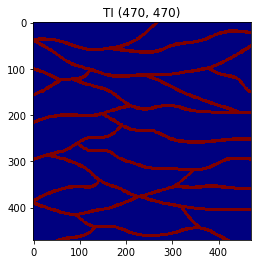

In [5]:
plot_im1(data)

# 2.Training data generation: 
## 10 000 samples 64x64

In [6]:
# Crop randomly the image
def random_crop(image):
  cropped_image = tf.image.random_crop(
      image, size=[64, 64])
  cropped_image=cropped_image.numpy()
  return cropped_image

In [7]:
# Generate 10 000 64x64 realizations
train_size=10000
training_data=[None] * train_size
for i in range(train_size):
    training_data[i]=random_crop(data)

(64, 64)


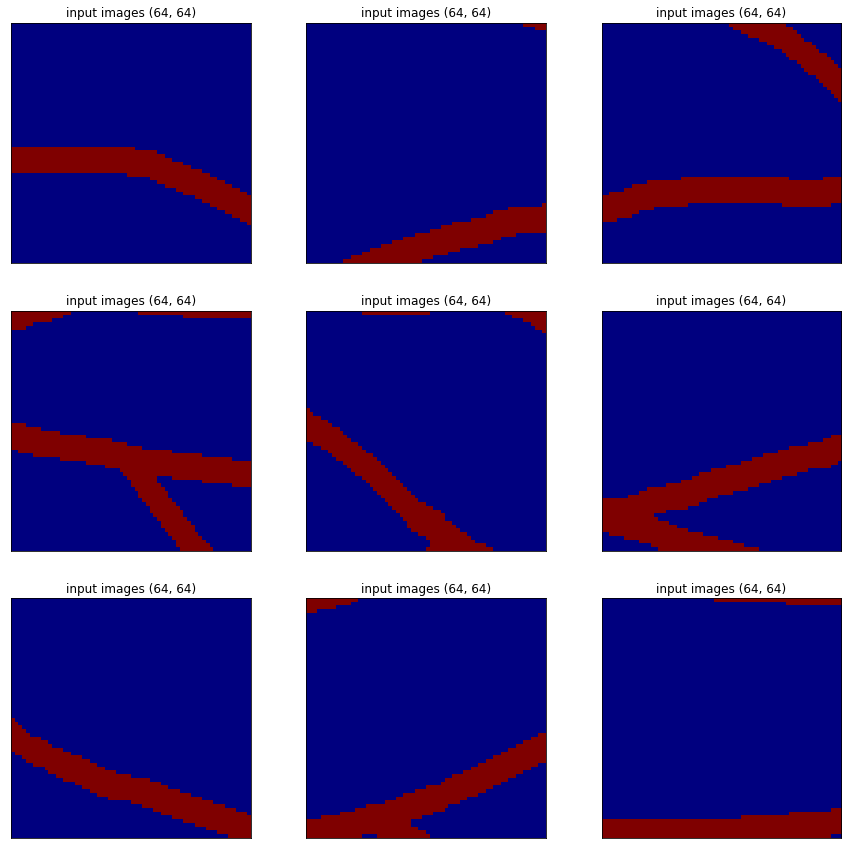

In [8]:
# plot some subset of images
print(training_data[1].shape)
#plot_im(training_data[3])
n = 10
plt.figure(figsize=(15, 15))
for i in range(9):
    # Display original
    ax = plt.subplot(3, 3, i + 1)
    #plt.imshow(test_x[i].reshape(28, 28))
    #plt.imshow(original[i])
    plt.imshow(training_data[i],interpolation='none')
    plt.jet()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title('input images '+str(training_data[1].shape))

# 3. GAN training

In [9]:
print(len(training_data)) #1200
print(training_data[1].shape)


10000
(64, 64)


In [10]:
training_data_np = np.dstack(training_data)
print(training_data_np.shape)
training_data_np = np.rollaxis(training_data_np,-1)
print(training_data_np.shape)

(64, 64, 10000)
(10000, 64, 64)


In [11]:
# define the standalone discriminator model
def define_discriminator(in_shape=(64,64,1)):
	model = Sequential()
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Flatten())
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = adam_v2.Adam(learning_rate=0.0002,beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

In [12]:
m=define_discriminator()
m.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        640       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32, 32, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 16384)             0

In [13]:
# define the standalone generator model
def define_generator(latent_dim):
	model = Sequential()
	# foundation for 7x7 image
	n_nodes = 64 * 16 * 16
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((16, 16, 64)))
	# upsample to 14x14
	model.add(Conv2DTranspose(100, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 28x28
	model.add(Conv2DTranspose(100, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2D(1, (16,16), activation='sigmoid', padding='same'))
	return model

In [14]:
g=define_generator(500)
g.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16384)             8208384   
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 16384)             0         
_________________________________________________________________
reshape (Reshape)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 32, 32, 100)       102500    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 32, 32, 100)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 64, 64, 100)       160100    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 64, 64, 100)      

In [15]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(g_model)
	# add the discriminator
	model.add(d_model)
	# compile model
	#opt = Adam(lr=0.0002, beta_1=0.5)
    #optimizer = keras.optimizers.Adam(lr=0.0002, decay=0.5)
	#optimizer1 = adam_v2.Adam(learning_rate=0.0002, decay=0.0002/1000)
	optimizer1 = adam_v2.Adam(learning_rate=0.0002,beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer = optimizer1)
	return model

In [16]:
# load and prepare mnist training images
def load_real_samples(a):
	# load mnist dataset
	
	# expand to 3d, e.g. add channels dimension
	X = expand_dims(a, axis=-1)
	# convert from unsigned ints to floats
	X = X.astype('float32')
	# scale from [0,255] to [0,1]
	#X = X / 255.0
	return X
 
# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = np.random.randint(low=0, high=dataset.shape[0], size=n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, 1))
	return X, y
 
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	#x_input =np.random.normal(loc=0.0, scale=1.0, size=latent_dim * n_samples)
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input
 
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = g_model.predict(x_input)
	# create 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y

In [17]:
# create and save a plot of generated images (reversed grayscale)
def save_plot(examples, epoch, n=10):
	# plot images
	for i in range(n * n):
		# define subplot
		plt.subplot(n, n, 1 + i)
		# turn off axis
		plt.axis('off')
		# plot raw pixel data
		#plt.imshow(examples[i, :, :, 0], cmap='gray_r')
		plt.imshow(examples[i, :, :, 0])
	# save plot to file
	filename = 'generated_plot_e%03d.png' % (epoch+1)
	plt.savefig(filename)
	plt.close()
 
# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
	# prepare real samples
	X_real, y_real = generate_real_samples(dataset, n_samples)
	# evaluate discriminator on real examples
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	# evaluate discriminator on fake examples
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
	# save plot
	save_plot(x_fake, epoch)
	# save the generator model tile file
	filename = 'generator_model_%03d.h5' % (epoch + 1)
	g_model.save(filename)

>1, 1/78, d=0.678, g=0.797
>1, 2/78, d=0.673, g=0.854
>1, 3/78, d=0.651, g=0.910
>1, 4/78, d=0.646, g=0.960
>1, 5/78, d=0.642, g=0.996
>1, 6/78, d=0.647, g=1.006
>1, 7/78, d=0.657, g=0.982
>1, 8/78, d=0.672, g=0.925
>1, 9/78, d=0.700, g=0.846
>1, 10/78, d=0.719, g=0.778
>1, 11/78, d=0.730, g=0.736
>1, 12/78, d=0.737, g=0.712
>1, 13/78, d=0.731, g=0.697
>1, 14/78, d=0.714, g=0.688
>1, 15/78, d=0.712, g=0.683
>1, 16/78, d=0.693, g=0.680
>1, 17/78, d=0.688, g=0.678
>1, 18/78, d=0.680, g=0.677
>1, 19/78, d=0.664, g=0.676
>1, 20/78, d=0.649, g=0.676
>1, 21/78, d=0.639, g=0.677
>1, 22/78, d=0.619, g=0.678
>1, 23/78, d=0.602, g=0.681
>1, 24/78, d=0.595, g=0.682
>1, 25/78, d=0.571, g=0.686
>1, 26/78, d=0.552, g=0.688
>1, 27/78, d=0.527, g=0.690
>1, 28/78, d=0.508, g=0.691
>1, 29/78, d=0.486, g=0.690
>1, 30/78, d=0.468, g=0.685
>1, 31/78, d=0.472, g=0.663
>1, 32/78, d=0.519, g=0.585
>1, 33/78, d=0.773, g=0.364
>1, 34/78, d=1.275, g=0.193
>1, 35/78, d=1.352, g=0.206
>1, 36/78, d=1.170, g=0.293
>

>4, 61/78, d=0.545, g=0.746
>4, 62/78, d=0.512, g=0.768
>4, 63/78, d=0.505, g=0.794
>4, 64/78, d=0.494, g=0.819
>4, 65/78, d=0.482, g=0.841
>4, 66/78, d=0.470, g=0.872
>4, 67/78, d=0.441, g=0.890
>4, 68/78, d=0.423, g=0.915
>4, 69/78, d=0.409, g=0.948
>4, 70/78, d=0.413, g=0.970
>4, 71/78, d=0.381, g=0.996
>4, 72/78, d=0.372, g=1.021
>4, 73/78, d=0.353, g=1.053
>4, 74/78, d=0.349, g=1.075
>4, 75/78, d=0.345, g=1.107
>4, 76/78, d=0.335, g=1.129
>4, 77/78, d=0.310, g=1.160
>4, 78/78, d=0.319, g=1.183
d_loss_1_length=4
>5, 1/78, d=0.301, g=1.212
>5, 2/78, d=0.290, g=1.232
>5, 3/78, d=0.274, g=1.262
>5, 4/78, d=0.260, g=1.290
>5, 5/78, d=0.254, g=1.324
>5, 6/78, d=0.246, g=1.352
>5, 7/78, d=0.249, g=1.372
>5, 8/78, d=0.217, g=1.408
>5, 9/78, d=0.219, g=1.443
>5, 10/78, d=0.229, g=1.468
>5, 11/78, d=0.224, g=1.492
>5, 12/78, d=0.219, g=1.513
>5, 13/78, d=0.202, g=1.545
>5, 14/78, d=0.182, g=1.568
>5, 15/78, d=0.204, g=1.594
>5, 16/78, d=0.189, g=1.618
>5, 17/78, d=0.178, g=1.647
>5, 18/78, 

>8, 42/78, d=0.384, g=1.359
>8, 43/78, d=0.378, g=1.360
>8, 44/78, d=0.398, g=1.400
>8, 45/78, d=0.403, g=1.255
>8, 46/78, d=0.389, g=1.203
>8, 47/78, d=0.417, g=1.353
>8, 48/78, d=0.418, g=1.304
>8, 49/78, d=0.399, g=1.349
>8, 50/78, d=0.360, g=1.303
>8, 51/78, d=0.398, g=1.286
>8, 52/78, d=0.375, g=1.303
>8, 53/78, d=0.416, g=1.239
>8, 54/78, d=0.394, g=1.235
>8, 55/78, d=0.418, g=1.184
>8, 56/78, d=0.376, g=1.351
>8, 57/78, d=0.393, g=1.288
>8, 58/78, d=0.397, g=1.193
>8, 59/78, d=0.449, g=1.404
>8, 60/78, d=0.493, g=1.456
>8, 61/78, d=0.421, g=1.229
>8, 62/78, d=0.422, g=1.070
>8, 63/78, d=0.471, g=1.136
>8, 64/78, d=0.428, g=1.353
>8, 65/78, d=0.456, g=1.344
>8, 66/78, d=0.407, g=1.335
>8, 67/78, d=0.496, g=1.137
>8, 68/78, d=0.488, g=1.399
>8, 69/78, d=0.473, g=1.407
>8, 70/78, d=0.442, g=1.367
>8, 71/78, d=0.428, g=1.144
>8, 72/78, d=0.513, g=1.173
>8, 73/78, d=0.416, g=1.117
>8, 74/78, d=0.496, g=1.106
>8, 75/78, d=0.478, g=1.266
>8, 76/78, d=0.487, g=1.227
>8, 77/78, d=0.483, 

>12, 9/78, d=0.665, g=0.820
>12, 10/78, d=0.653, g=0.847
>12, 11/78, d=0.645, g=0.818
>12, 12/78, d=0.631, g=0.860
>12, 13/78, d=0.632, g=0.812
>12, 14/78, d=0.615, g=0.770
>12, 15/78, d=0.628, g=0.828
>12, 16/78, d=0.624, g=0.802
>12, 17/78, d=0.632, g=0.864
>12, 18/78, d=0.639, g=0.908
>12, 19/78, d=0.651, g=0.860
>12, 20/78, d=0.648, g=0.816
>12, 21/78, d=0.617, g=0.802
>12, 22/78, d=0.659, g=0.810
>12, 23/78, d=0.629, g=0.793
>12, 24/78, d=0.625, g=0.889
>12, 25/78, d=0.636, g=0.834
>12, 26/78, d=0.635, g=0.877
>12, 27/78, d=0.660, g=0.819
>12, 28/78, d=0.632, g=0.757
>12, 29/78, d=0.630, g=0.820
>12, 30/78, d=0.652, g=0.804
>12, 31/78, d=0.626, g=0.839
>12, 32/78, d=0.631, g=0.873
>12, 33/78, d=0.626, g=0.803
>12, 34/78, d=0.624, g=0.790
>12, 35/78, d=0.618, g=0.825
>12, 36/78, d=0.630, g=0.755
>12, 37/78, d=0.629, g=0.795
>12, 38/78, d=0.612, g=0.833
>12, 39/78, d=0.632, g=0.843
>12, 40/78, d=0.638, g=0.866
>12, 41/78, d=0.673, g=0.842
>12, 42/78, d=0.636, g=0.854
>12, 43/78, d=0

>15, 57/78, d=0.664, g=0.799
>15, 58/78, d=0.648, g=0.771
>15, 59/78, d=0.647, g=0.791
>15, 60/78, d=0.617, g=0.759
>15, 61/78, d=0.640, g=0.754
>15, 62/78, d=0.630, g=0.813
>15, 63/78, d=0.626, g=0.807
>15, 64/78, d=0.638, g=0.757
>15, 65/78, d=0.632, g=0.759
>15, 66/78, d=0.635, g=0.795
>15, 67/78, d=0.646, g=0.791
>15, 68/78, d=0.633, g=0.791
>15, 69/78, d=0.641, g=0.725
>15, 70/78, d=0.650, g=0.776
>15, 71/78, d=0.631, g=0.750
>15, 72/78, d=0.625, g=0.731
>15, 73/78, d=0.656, g=0.790
>15, 74/78, d=0.626, g=0.782
>15, 75/78, d=0.631, g=0.810
>15, 76/78, d=0.620, g=0.802
>15, 77/78, d=0.665, g=0.854
>15, 78/78, d=0.638, g=0.882
d_loss_1_length=15
>16, 1/78, d=0.649, g=0.795
>16, 2/78, d=0.633, g=0.766
>16, 3/78, d=0.638, g=0.772
>16, 4/78, d=0.650, g=0.778
>16, 5/78, d=0.650, g=0.804
>16, 6/78, d=0.651, g=0.894
>16, 7/78, d=0.655, g=0.769
>16, 8/78, d=0.620, g=0.773
>16, 9/78, d=0.624, g=0.730
>16, 10/78, d=0.640, g=0.746
>16, 11/78, d=0.637, g=0.792
>16, 12/78, d=0.634, g=0.831
>16,

>19, 28/78, d=0.623, g=0.829
>19, 29/78, d=0.615, g=0.822
>19, 30/78, d=0.638, g=0.808
>19, 31/78, d=0.618, g=0.777
>19, 32/78, d=0.600, g=0.767
>19, 33/78, d=0.615, g=0.879
>19, 34/78, d=0.633, g=0.840
>19, 35/78, d=0.615, g=0.816
>19, 36/78, d=0.596, g=0.793
>19, 37/78, d=0.608, g=0.802
>19, 38/78, d=0.633, g=0.831
>19, 39/78, d=0.610, g=0.768
>19, 40/78, d=0.632, g=0.815
>19, 41/78, d=0.612, g=0.801
>19, 42/78, d=0.608, g=0.823
>19, 43/78, d=0.624, g=0.762
>19, 44/78, d=0.605, g=0.859
>19, 45/78, d=0.609, g=0.776
>19, 46/78, d=0.601, g=0.728
>19, 47/78, d=0.648, g=0.883
>19, 48/78, d=0.630, g=0.869
>19, 49/78, d=0.602, g=0.803
>19, 50/78, d=0.617, g=0.875
>19, 51/78, d=0.638, g=0.752
>19, 52/78, d=0.610, g=0.828
>19, 53/78, d=0.647, g=0.911
>19, 54/78, d=0.635, g=0.750
>19, 55/78, d=0.589, g=0.798
>19, 56/78, d=0.634, g=0.740
>19, 57/78, d=0.623, g=0.847
>19, 58/78, d=0.603, g=0.885
>19, 59/78, d=0.601, g=0.785
>19, 60/78, d=0.585, g=0.782
>19, 61/78, d=0.614, g=0.908
>19, 62/78, d=

>22, 69/78, d=0.644, g=1.007
>22, 70/78, d=0.644, g=0.713
>22, 71/78, d=0.635, g=0.905
>22, 72/78, d=0.604, g=0.836
>22, 73/78, d=0.602, g=0.728
>22, 74/78, d=0.609, g=0.987
>22, 75/78, d=0.611, g=0.744
>22, 76/78, d=0.614, g=0.746
>22, 77/78, d=0.603, g=0.885
>22, 78/78, d=0.621, g=0.826
d_loss_1_length=22
>23, 1/78, d=0.591, g=0.819
>23, 2/78, d=0.612, g=0.959
>23, 3/78, d=0.586, g=0.790
>23, 4/78, d=0.638, g=0.810
>23, 5/78, d=0.631, g=0.850
>23, 6/78, d=0.629, g=0.758
>23, 7/78, d=0.631, g=0.842
>23, 8/78, d=0.610, g=0.834
>23, 9/78, d=0.636, g=0.726
>23, 10/78, d=0.637, g=0.934
>23, 11/78, d=0.650, g=0.697
>23, 12/78, d=0.629, g=0.954
>23, 13/78, d=0.595, g=0.753
>23, 14/78, d=0.605, g=0.791
>23, 15/78, d=0.592, g=0.914
>23, 16/78, d=0.619, g=0.875
>23, 17/78, d=0.573, g=0.790
>23, 18/78, d=0.663, g=0.827
>23, 19/78, d=0.612, g=0.828
>23, 20/78, d=0.642, g=0.869
>23, 21/78, d=0.640, g=0.761
>23, 22/78, d=0.581, g=0.902
>23, 23/78, d=0.587, g=0.892
>23, 24/78, d=0.594, g=0.852
>23,

>26, 41/78, d=0.596, g=0.816
>26, 42/78, d=0.578, g=0.784
>26, 43/78, d=0.570, g=0.922
>26, 44/78, d=0.571, g=0.880
>26, 45/78, d=0.629, g=0.820
>26, 46/78, d=0.606, g=0.792
>26, 47/78, d=0.568, g=0.987
>26, 48/78, d=0.622, g=0.873
>26, 49/78, d=0.558, g=0.803
>26, 50/78, d=0.575, g=0.985
>26, 51/78, d=0.590, g=0.830
>26, 52/78, d=0.599, g=0.998
>26, 53/78, d=0.579, g=0.770
>26, 54/78, d=0.573, g=0.903
>26, 55/78, d=0.576, g=0.944
>26, 56/78, d=0.614, g=0.797
>26, 57/78, d=0.600, g=0.938
>26, 58/78, d=0.579, g=0.866
>26, 59/78, d=0.624, g=0.835
>26, 60/78, d=0.553, g=0.801
>26, 61/78, d=0.635, g=0.934
>26, 62/78, d=0.579, g=0.911
>26, 63/78, d=0.587, g=0.700
>26, 64/78, d=0.575, g=0.938
>26, 65/78, d=0.600, g=0.762
>26, 66/78, d=0.580, g=0.947
>26, 67/78, d=0.584, g=0.787
>26, 68/78, d=0.589, g=0.900
>26, 69/78, d=0.578, g=0.990
>26, 70/78, d=0.586, g=0.761
>26, 71/78, d=0.604, g=0.887
>26, 72/78, d=0.588, g=0.987
>26, 73/78, d=0.603, g=0.813
>26, 74/78, d=0.604, g=0.820
>26, 75/78, d=

>30, 11/78, d=0.542, g=0.874
>30, 12/78, d=0.564, g=1.072
>30, 13/78, d=0.619, g=0.829
>30, 14/78, d=0.584, g=0.897
>30, 15/78, d=0.577, g=1.121
>30, 16/78, d=0.562, g=0.816
>30, 17/78, d=0.530, g=0.887
>30, 18/78, d=0.561, g=0.882
>30, 19/78, d=0.546, g=0.974
>30, 20/78, d=0.570, g=0.767
>30, 21/78, d=0.573, g=1.217
>30, 22/78, d=0.598, g=0.769
>30, 23/78, d=0.592, g=0.963
>30, 24/78, d=0.574, g=1.256
>30, 25/78, d=0.599, g=0.731
>30, 26/78, d=0.582, g=1.007
>30, 27/78, d=0.601, g=1.062
>30, 28/78, d=0.521, g=0.904
>30, 29/78, d=0.541, g=1.113
>30, 30/78, d=0.555, g=0.850
>30, 31/78, d=0.601, g=0.710
>30, 32/78, d=0.593, g=1.077
>30, 33/78, d=0.577, g=1.007
>30, 34/78, d=0.581, g=0.867
>30, 35/78, d=0.576, g=0.937
>30, 36/78, d=0.575, g=0.952
>30, 37/78, d=0.538, g=0.821
>30, 38/78, d=0.567, g=1.130
>30, 39/78, d=0.582, g=0.786
>30, 40/78, d=0.572, g=0.916
>30, 41/78, d=0.558, g=1.058
>30, 42/78, d=0.584, g=0.724
>30, 43/78, d=0.608, g=1.124
>30, 44/78, d=0.568, g=0.967
>30, 45/78, d=

>33, 54/78, d=0.520, g=0.847
>33, 55/78, d=0.550, g=0.953
>33, 56/78, d=0.532, g=0.982
>33, 57/78, d=0.519, g=0.883
>33, 58/78, d=0.545, g=1.147
>33, 59/78, d=0.543, g=1.056
>33, 60/78, d=0.540, g=1.000
>33, 61/78, d=0.517, g=0.929
>33, 62/78, d=0.543, g=1.079
>33, 63/78, d=0.536, g=0.788
>33, 64/78, d=0.575, g=1.114
>33, 65/78, d=0.576, g=0.962
>33, 66/78, d=0.548, g=0.938
>33, 67/78, d=0.536, g=0.786
>33, 68/78, d=0.556, g=1.250
>33, 69/78, d=0.530, g=0.815
>33, 70/78, d=0.563, g=1.270
>33, 71/78, d=0.536, g=1.036
>33, 72/78, d=0.559, g=0.826
>33, 73/78, d=0.519, g=1.112
>33, 74/78, d=0.569, g=0.850
>33, 75/78, d=0.574, g=1.010
>33, 76/78, d=0.541, g=1.035
>33, 77/78, d=0.551, g=1.053
>33, 78/78, d=0.515, g=0.925
d_loss_1_length=33
>34, 1/78, d=0.504, g=0.861
>34, 2/78, d=0.502, g=1.206
>34, 3/78, d=0.547, g=0.915
>34, 4/78, d=0.553, g=0.922
>34, 5/78, d=0.528, g=1.047
>34, 6/78, d=0.514, g=1.016
>34, 7/78, d=0.530, g=0.942
>34, 8/78, d=0.522, g=1.072
>34, 9/78, d=0.531, g=0.969
>34,

>37, 24/78, d=0.551, g=1.141
>37, 25/78, d=0.559, g=0.894
>37, 26/78, d=0.596, g=1.139
>37, 27/78, d=0.534, g=0.990
>37, 28/78, d=0.493, g=0.929
>37, 29/78, d=0.519, g=1.317
>37, 30/78, d=0.532, g=1.006
>37, 31/78, d=0.527, g=1.254
>37, 32/78, d=0.529, g=0.992
>37, 33/78, d=0.517, g=1.165
>37, 34/78, d=0.505, g=1.141
>37, 35/78, d=0.493, g=0.936
>37, 36/78, d=0.549, g=1.009
>37, 37/78, d=0.505, g=1.071
>37, 38/78, d=0.529, g=1.160
>37, 39/78, d=0.514, g=1.155
>37, 40/78, d=0.510, g=0.911
>37, 41/78, d=0.511, g=1.553
>37, 42/78, d=0.547, g=0.843
>37, 43/78, d=0.516, g=0.932
>37, 44/78, d=0.522, g=1.080
>37, 45/78, d=0.491, g=1.036
>37, 46/78, d=0.543, g=1.018
>37, 47/78, d=0.547, g=1.030
>37, 48/78, d=0.487, g=1.205
>37, 49/78, d=0.535, g=1.097
>37, 50/78, d=0.544, g=0.822
>37, 51/78, d=0.499, g=1.172
>37, 52/78, d=0.568, g=1.107
>37, 53/78, d=0.494, g=1.046
>37, 54/78, d=0.473, g=0.939
>37, 55/78, d=0.487, g=1.088
>37, 56/78, d=0.484, g=1.193
>37, 57/78, d=0.522, g=1.100
>37, 58/78, d=

>40, 73/78, d=0.527, g=1.101
>40, 74/78, d=0.484, g=1.086
>40, 75/78, d=0.519, g=0.950
>40, 76/78, d=0.487, g=1.177
>40, 77/78, d=0.523, g=1.207
>40, 78/78, d=0.498, g=1.023
>Accuracy real: 100%, fake: 42%
d_loss_1_length=40
>41, 1/78, d=0.617, g=1.303
>41, 2/78, d=0.543, g=1.075
>41, 3/78, d=0.487, g=1.183
>41, 4/78, d=0.464, g=1.062
>41, 5/78, d=0.495, g=1.213
>41, 6/78, d=0.485, g=0.956
>41, 7/78, d=0.460, g=1.286
>41, 8/78, d=0.498, g=1.099
>41, 9/78, d=0.498, g=1.217
>41, 10/78, d=0.517, g=1.087
>41, 11/78, d=0.486, g=1.177
>41, 12/78, d=0.450, g=1.147
>41, 13/78, d=0.436, g=0.958
>41, 14/78, d=0.500, g=1.307
>41, 15/78, d=0.496, g=1.286
>41, 16/78, d=0.467, g=1.128
>41, 17/78, d=0.492, g=1.238
>41, 18/78, d=0.459, g=1.261
>41, 19/78, d=0.471, g=1.131
>41, 20/78, d=0.453, g=1.209
>41, 21/78, d=0.462, g=1.457
>41, 22/78, d=0.525, g=0.871
>41, 23/78, d=0.546, g=1.504
>41, 24/78, d=0.480, g=1.098
>41, 25/78, d=0.464, g=1.120
>41, 26/78, d=0.448, g=1.144
>41, 27/78, d=0.487, g=1.068
>

>44, 36/78, d=0.498, g=1.327
>44, 37/78, d=0.488, g=1.415
>44, 38/78, d=0.472, g=0.960
>44, 39/78, d=0.480, g=1.487
>44, 40/78, d=0.483, g=0.981
>44, 41/78, d=0.491, g=1.391
>44, 42/78, d=0.463, g=0.971
>44, 43/78, d=0.470, g=1.200
>44, 44/78, d=0.511, g=1.592
>44, 45/78, d=0.482, g=1.248
>44, 46/78, d=0.496, g=1.165
>44, 47/78, d=0.515, g=1.696
>44, 48/78, d=0.475, g=1.159
>44, 49/78, d=0.458, g=1.204
>44, 50/78, d=0.442, g=1.188
>44, 51/78, d=0.419, g=1.117
>44, 52/78, d=0.482, g=1.304
>44, 53/78, d=0.427, g=1.453
>44, 54/78, d=0.493, g=1.074
>44, 55/78, d=0.463, g=1.533
>44, 56/78, d=0.484, g=1.082
>44, 57/78, d=0.439, g=0.898
>44, 58/78, d=0.442, g=1.208
>44, 59/78, d=0.473, g=1.685
>44, 60/78, d=0.536, g=1.005
>44, 61/78, d=0.530, g=1.216
>44, 62/78, d=0.439, g=1.241
>44, 63/78, d=0.434, g=1.330
>44, 64/78, d=0.489, g=1.080
>44, 65/78, d=0.414, g=1.253
>44, 66/78, d=0.432, g=1.243
>44, 67/78, d=0.472, g=1.141
>44, 68/78, d=0.456, g=1.257
>44, 69/78, d=0.417, g=1.267
>44, 70/78, d=

>48, 5/78, d=0.521, g=1.555
>48, 6/78, d=0.443, g=1.465
>48, 7/78, d=0.440, g=1.123
>48, 8/78, d=0.407, g=1.055
>48, 9/78, d=0.496, g=1.620
>48, 10/78, d=0.420, g=1.426
>48, 11/78, d=0.490, g=1.229
>48, 12/78, d=0.494, g=1.520
>48, 13/78, d=0.489, g=1.362
>48, 14/78, d=0.490, g=0.973
>48, 15/78, d=0.485, g=1.380
>48, 16/78, d=0.453, g=1.313
>48, 17/78, d=0.443, g=1.348
>48, 18/78, d=0.444, g=1.436
>48, 19/78, d=0.431, g=1.362
>48, 20/78, d=0.480, g=1.393
>48, 21/78, d=0.488, g=1.429
>48, 22/78, d=0.451, g=1.263
>48, 23/78, d=0.427, g=1.402
>48, 24/78, d=0.448, g=1.309
>48, 25/78, d=0.467, g=1.180
>48, 26/78, d=0.462, g=1.205
>48, 27/78, d=0.488, g=1.672
>48, 28/78, d=0.490, g=0.941
>48, 29/78, d=0.502, g=1.290
>48, 30/78, d=0.483, g=1.202
>48, 31/78, d=0.505, g=1.267
>48, 32/78, d=0.478, g=1.028
>48, 33/78, d=0.532, g=1.336
>48, 34/78, d=0.510, g=1.152
>48, 35/78, d=0.525, g=1.195
>48, 36/78, d=0.568, g=1.438
>48, 37/78, d=0.486, g=0.883
>48, 38/78, d=0.492, g=1.506
>48, 39/78, d=0.558

>51, 47/78, d=0.471, g=1.516
>51, 48/78, d=0.456, g=1.250
>51, 49/78, d=0.427, g=1.377
>51, 50/78, d=0.455, g=1.341
>51, 51/78, d=0.455, g=1.250
>51, 52/78, d=0.496, g=1.449
>51, 53/78, d=0.398, g=1.277
>51, 54/78, d=0.467, g=1.557
>51, 55/78, d=0.488, g=1.577
>51, 56/78, d=0.491, g=1.242
>51, 57/78, d=0.438, g=1.239
>51, 58/78, d=0.458, g=1.616
>51, 59/78, d=0.459, g=1.395
>51, 60/78, d=0.406, g=1.150
>51, 61/78, d=0.466, g=1.411
>51, 62/78, d=0.515, g=1.450
>51, 63/78, d=0.415, g=1.324
>51, 64/78, d=0.479, g=1.207
>51, 65/78, d=0.409, g=1.501
>51, 66/78, d=0.440, g=1.162
>51, 67/78, d=0.394, g=1.423
>51, 68/78, d=0.428, g=1.598
>51, 69/78, d=0.485, g=1.051
>51, 70/78, d=0.496, g=1.571
>51, 71/78, d=0.456, g=1.138
>51, 72/78, d=0.483, g=1.844
>51, 73/78, d=0.544, g=1.337
>51, 74/78, d=0.464, g=1.295
>51, 75/78, d=0.431, g=1.582
>51, 76/78, d=0.418, g=1.269
>51, 77/78, d=0.487, g=1.526
>51, 78/78, d=0.462, g=1.548
d_loss_1_length=51
>52, 1/78, d=0.451, g=1.041
>52, 2/78, d=0.441, g=1.7

>55, 17/78, d=0.427, g=1.143
>55, 18/78, d=0.460, g=1.240
>55, 19/78, d=0.412, g=1.491
>55, 20/78, d=0.450, g=1.445
>55, 21/78, d=0.412, g=1.366
>55, 22/78, d=0.470, g=1.198
>55, 23/78, d=0.417, g=1.617
>55, 24/78, d=0.445, g=1.296
>55, 25/78, d=0.423, g=1.300
>55, 26/78, d=0.462, g=1.445
>55, 27/78, d=0.438, g=1.270
>55, 28/78, d=0.418, g=1.316
>55, 29/78, d=0.434, g=1.333
>55, 30/78, d=0.428, g=1.548
>55, 31/78, d=0.444, g=1.522
>55, 32/78, d=0.448, g=1.251
>55, 33/78, d=0.459, g=1.489
>55, 34/78, d=0.457, g=1.710
>55, 35/78, d=0.511, g=1.157
>55, 36/78, d=0.413, g=1.280
>55, 37/78, d=0.396, g=1.313
>55, 38/78, d=0.450, g=1.626
>55, 39/78, d=0.447, g=1.453
>55, 40/78, d=0.387, g=1.132
>55, 41/78, d=0.424, g=1.349
>55, 42/78, d=0.381, g=1.636
>55, 43/78, d=0.506, g=1.359
>55, 44/78, d=0.513, g=1.267
>55, 45/78, d=0.452, g=1.433
>55, 46/78, d=0.476, g=1.248
>55, 47/78, d=0.413, g=1.467
>55, 48/78, d=0.457, g=1.424
>55, 49/78, d=0.448, g=1.375
>55, 50/78, d=0.476, g=1.408
>55, 51/78, d=

>58, 65/78, d=0.503, g=1.326
>58, 66/78, d=0.483, g=1.483
>58, 67/78, d=0.550, g=1.298
>58, 68/78, d=0.535, g=1.182
>58, 69/78, d=0.510, g=1.310
>58, 70/78, d=0.439, g=1.232
>58, 71/78, d=0.436, g=1.296
>58, 72/78, d=0.544, g=1.774
>58, 73/78, d=0.531, g=1.270
>58, 74/78, d=0.552, g=1.573
>58, 75/78, d=0.458, g=1.485
>58, 76/78, d=0.459, g=1.308
>58, 77/78, d=0.464, g=1.475
>58, 78/78, d=0.468, g=1.298
d_loss_1_length=58
>59, 1/78, d=0.424, g=1.398
>59, 2/78, d=0.463, g=1.231
>59, 3/78, d=0.438, g=1.137
>59, 4/78, d=0.452, g=1.570
>59, 5/78, d=0.424, g=1.445
>59, 6/78, d=0.482, g=1.085
>59, 7/78, d=0.505, g=1.389
>59, 8/78, d=0.426, g=1.446
>59, 9/78, d=0.491, g=1.411
>59, 10/78, d=0.438, g=1.260
>59, 11/78, d=0.498, g=1.935
>59, 12/78, d=0.477, g=1.529
>59, 13/78, d=0.489, g=1.356
>59, 14/78, d=0.513, g=1.493
>59, 15/78, d=0.457, g=1.311
>59, 16/78, d=0.473, g=1.236
>59, 17/78, d=0.443, g=1.534
>59, 18/78, d=0.468, g=1.846
>59, 19/78, d=0.485, g=1.041
>59, 20/78, d=0.445, g=1.096
>59,

>62, 29/78, d=0.498, g=1.603
>62, 30/78, d=0.455, g=1.322
>62, 31/78, d=0.405, g=1.596
>62, 32/78, d=0.423, g=1.168
>62, 33/78, d=0.389, g=1.230
>62, 34/78, d=0.476, g=1.473
>62, 35/78, d=0.415, g=1.624
>62, 36/78, d=0.407, g=1.263
>62, 37/78, d=0.509, g=1.482
>62, 38/78, d=0.416, g=1.387
>62, 39/78, d=0.436, g=1.513
>62, 40/78, d=0.453, g=1.196
>62, 41/78, d=0.435, g=1.363
>62, 42/78, d=0.417, g=1.746
>62, 43/78, d=0.441, g=1.354
>62, 44/78, d=0.433, g=1.196
>62, 45/78, d=0.493, g=1.482
>62, 46/78, d=0.448, g=1.465
>62, 47/78, d=0.416, g=1.537
>62, 48/78, d=0.431, g=1.763
>62, 49/78, d=0.431, g=1.352
>62, 50/78, d=0.384, g=1.227
>62, 51/78, d=0.496, g=1.824
>62, 52/78, d=0.411, g=1.443
>62, 53/78, d=0.465, g=1.277
>62, 54/78, d=0.468, g=1.070
>62, 55/78, d=0.515, g=1.511
>62, 56/78, d=0.402, g=1.817
>62, 57/78, d=0.438, g=1.073
>62, 58/78, d=0.596, g=1.642
>62, 59/78, d=0.447, g=1.539
>62, 60/78, d=0.422, g=1.410
>62, 61/78, d=0.396, g=1.499
>62, 62/78, d=0.417, g=1.235
>62, 63/78, d=

>65, 78/78, d=0.442, g=1.579
d_loss_1_length=65
>66, 1/78, d=0.474, g=1.128
>66, 2/78, d=0.404, g=1.384
>66, 3/78, d=0.457, g=1.649
>66, 4/78, d=0.451, g=1.453
>66, 5/78, d=0.475, g=1.448
>66, 6/78, d=0.435, g=1.480
>66, 7/78, d=0.449, g=1.637
>66, 8/78, d=0.427, g=1.504
>66, 9/78, d=0.369, g=1.349
>66, 10/78, d=0.463, g=1.661
>66, 11/78, d=0.418, g=1.786
>66, 12/78, d=0.491, g=1.082
>66, 13/78, d=0.402, g=1.356
>66, 14/78, d=0.414, g=1.706
>66, 15/78, d=0.431, g=1.597
>66, 16/78, d=0.471, g=1.474
>66, 17/78, d=0.428, g=1.563
>66, 18/78, d=0.460, g=1.470
>66, 19/78, d=0.454, g=1.772
>66, 20/78, d=0.339, g=1.355
>66, 21/78, d=0.472, g=1.250
>66, 22/78, d=0.432, g=1.477
>66, 23/78, d=0.445, g=2.071
>66, 24/78, d=0.454, g=1.596
>66, 25/78, d=0.506, g=1.281
>66, 26/78, d=0.392, g=1.459
>66, 27/78, d=0.511, g=1.732
>66, 28/78, d=0.436, g=1.348
>66, 29/78, d=0.439, g=1.380
>66, 30/78, d=0.419, g=1.667
>66, 31/78, d=0.472, g=1.607
>66, 32/78, d=0.441, g=1.591
>66, 33/78, d=0.427, g=1.405
>66,

>69, 48/78, d=0.424, g=1.708
>69, 49/78, d=0.370, g=1.337
>69, 50/78, d=0.391, g=1.086
>69, 51/78, d=0.427, g=1.420
>69, 52/78, d=0.435, g=1.920
>69, 53/78, d=0.470, g=1.460
>69, 54/78, d=0.448, g=1.422
>69, 55/78, d=0.370, g=1.509
>69, 56/78, d=0.470, g=1.619
>69, 57/78, d=0.434, g=1.503
>69, 58/78, d=0.423, g=1.293
>69, 59/78, d=0.473, g=1.470
>69, 60/78, d=0.450, g=1.543
>69, 61/78, d=0.409, g=1.327
>69, 62/78, d=0.449, g=1.501
>69, 63/78, d=0.383, g=1.538
>69, 64/78, d=0.449, g=1.349
>69, 65/78, d=0.455, g=1.596
>69, 66/78, d=0.450, g=1.694
>69, 67/78, d=0.410, g=1.296
>69, 68/78, d=0.372, g=1.107
>69, 69/78, d=0.452, g=1.636
>69, 70/78, d=0.446, g=1.694
>69, 71/78, d=0.427, g=1.285
>69, 72/78, d=0.453, g=1.543
>69, 73/78, d=0.438, g=1.643
>69, 74/78, d=0.430, g=1.717
>69, 75/78, d=0.402, g=1.310
>69, 76/78, d=0.468, g=1.568
>69, 77/78, d=0.525, g=1.817
>69, 78/78, d=0.442, g=0.943
d_loss_1_length=69
>70, 1/78, d=0.465, g=1.647
>70, 2/78, d=0.490, g=1.761
>70, 3/78, d=0.462, g=1.22

>73, 11/78, d=0.440, g=1.577
>73, 12/78, d=0.511, g=1.699
>73, 13/78, d=0.362, g=1.687
>73, 14/78, d=0.385, g=1.352
>73, 15/78, d=0.406, g=1.265
>73, 16/78, d=0.431, g=1.406
>73, 17/78, d=0.430, g=1.586
>73, 18/78, d=0.441, g=1.467
>73, 19/78, d=0.384, g=1.513
>73, 20/78, d=0.497, g=1.512
>73, 21/78, d=0.446, g=1.274
>73, 22/78, d=0.450, g=1.415
>73, 23/78, d=0.448, g=1.422
>73, 24/78, d=0.514, g=1.253
>73, 25/78, d=0.501, g=1.809
>73, 26/78, d=0.414, g=1.542
>73, 27/78, d=0.459, g=1.422
>73, 28/78, d=0.467, g=1.539
>73, 29/78, d=0.440, g=1.785
>73, 30/78, d=0.435, g=1.375
>73, 31/78, d=0.402, g=1.792
>73, 32/78, d=0.497, g=1.348
>73, 33/78, d=0.423, g=1.743
>73, 34/78, d=0.404, g=1.647
>73, 35/78, d=0.436, g=1.265
>73, 36/78, d=0.474, g=1.729
>73, 37/78, d=0.465, g=1.363
>73, 38/78, d=0.402, g=1.299
>73, 39/78, d=0.435, g=1.425
>73, 40/78, d=0.424, g=1.751
>73, 41/78, d=0.499, g=1.729
>73, 42/78, d=0.443, g=1.661
>73, 43/78, d=0.418, g=1.452
>73, 44/78, d=0.473, g=1.612
>73, 45/78, d=

>76, 59/78, d=0.428, g=1.576
>76, 60/78, d=0.399, g=1.550
>76, 61/78, d=0.348, g=1.311
>76, 62/78, d=0.466, g=1.554
>76, 63/78, d=0.449, g=1.575
>76, 64/78, d=0.444, g=1.469
>76, 65/78, d=0.499, g=1.496
>76, 66/78, d=0.441, g=1.553
>76, 67/78, d=0.386, g=1.729
>76, 68/78, d=0.424, g=1.198
>76, 69/78, d=0.415, g=1.623
>76, 70/78, d=0.412, g=1.805
>76, 71/78, d=0.451, g=1.341
>76, 72/78, d=0.401, g=1.478
>76, 73/78, d=0.374, g=1.681
>76, 74/78, d=0.426, g=1.476
>76, 75/78, d=0.469, g=1.878
>76, 76/78, d=0.410, g=1.391
>76, 77/78, d=0.462, g=1.879
>76, 78/78, d=0.422, g=1.753
d_loss_1_length=76
>77, 1/78, d=0.459, g=1.639
>77, 2/78, d=0.406, g=1.216
>77, 3/78, d=0.504, g=1.676
>77, 4/78, d=0.427, g=1.441
>77, 5/78, d=0.362, g=1.579
>77, 6/78, d=0.417, g=1.553
>77, 7/78, d=0.453, g=1.640
>77, 8/78, d=0.427, g=1.200
>77, 9/78, d=0.403, g=1.612
>77, 10/78, d=0.434, g=2.017
>77, 11/78, d=0.440, g=1.274
>77, 12/78, d=0.419, g=1.535
>77, 13/78, d=0.371, g=1.666
>77, 14/78, d=0.459, g=1.869
>77,

>80, 29/78, d=0.461, g=1.687
>80, 30/78, d=0.475, g=1.123
>80, 31/78, d=0.502, g=1.574
>80, 32/78, d=0.419, g=1.889
>80, 33/78, d=0.421, g=1.556
>80, 34/78, d=0.339, g=1.697
>80, 35/78, d=0.411, g=1.379
>80, 36/78, d=0.414, g=1.528
>80, 37/78, d=0.419, g=1.532
>80, 38/78, d=0.409, g=1.771
>80, 39/78, d=0.492, g=1.319
>80, 40/78, d=0.427, g=1.311
>80, 41/78, d=0.512, g=2.120
>80, 42/78, d=0.408, g=1.397
>80, 43/78, d=0.418, g=1.448
>80, 44/78, d=0.467, g=1.846
>80, 45/78, d=0.309, g=1.643
>80, 46/78, d=0.380, g=1.482
>80, 47/78, d=0.413, g=1.470
>80, 48/78, d=0.429, g=1.472
>80, 49/78, d=0.395, g=1.457
>80, 50/78, d=0.399, g=1.270
>80, 51/78, d=0.464, g=1.410
>80, 52/78, d=0.417, g=1.817
>80, 53/78, d=0.458, g=1.355
>80, 54/78, d=0.451, g=1.520
>80, 55/78, d=0.433, g=1.956
>80, 56/78, d=0.474, g=1.313
>80, 57/78, d=0.419, g=1.429
>80, 58/78, d=0.379, g=1.365
>80, 59/78, d=0.452, g=1.406
>80, 60/78, d=0.459, g=1.525
>80, 61/78, d=0.416, g=1.666
>80, 62/78, d=0.534, g=1.968
>80, 63/78, d=

>83, 72/78, d=0.389, g=1.162
>83, 73/78, d=0.446, g=1.829
>83, 74/78, d=0.423, g=1.417
>83, 75/78, d=0.390, g=1.681
>83, 76/78, d=0.423, g=1.531
>83, 77/78, d=0.503, g=1.511
>83, 78/78, d=0.387, g=1.624
d_loss_1_length=83
>84, 1/78, d=0.453, g=1.333
>84, 2/78, d=0.444, g=1.696
>84, 3/78, d=0.360, g=1.686
>84, 4/78, d=0.440, g=1.766
>84, 5/78, d=0.344, g=1.512
>84, 6/78, d=0.404, g=1.613
>84, 7/78, d=0.470, g=1.638
>84, 8/78, d=0.417, g=1.707
>84, 9/78, d=0.468, g=1.245
>84, 10/78, d=0.363, g=1.304
>84, 11/78, d=0.390, g=1.627
>84, 12/78, d=0.409, g=1.413
>84, 13/78, d=0.419, g=1.889
>84, 14/78, d=0.430, g=1.747
>84, 15/78, d=0.475, g=1.563
>84, 16/78, d=0.473, g=1.377
>84, 17/78, d=0.487, g=1.877
>84, 18/78, d=0.383, g=1.579
>84, 19/78, d=0.404, g=1.416
>84, 20/78, d=0.458, g=1.650
>84, 21/78, d=0.414, g=1.555
>84, 22/78, d=0.364, g=1.672
>84, 23/78, d=0.508, g=1.599
>84, 24/78, d=0.454, g=1.623
>84, 25/78, d=0.455, g=1.399
>84, 26/78, d=0.423, g=1.531
>84, 27/78, d=0.398, g=1.642
>84,

>87, 43/78, d=0.415, g=1.735
>87, 44/78, d=0.443, g=1.322
>87, 45/78, d=0.427, g=1.488
>87, 46/78, d=0.448, g=1.539
>87, 47/78, d=0.417, g=1.694
>87, 48/78, d=0.509, g=1.348
>87, 49/78, d=0.529, g=1.543
>87, 50/78, d=0.380, g=1.550
>87, 51/78, d=0.406, g=1.552
>87, 52/78, d=0.394, g=1.447
>87, 53/78, d=0.405, g=1.751
>87, 54/78, d=0.487, g=1.785
>87, 55/78, d=0.430, g=1.512
>87, 56/78, d=0.430, g=1.428
>87, 57/78, d=0.487, g=1.568
>87, 58/78, d=0.573, g=1.937
>87, 59/78, d=0.422, g=1.386
>87, 60/78, d=0.409, g=1.546
>87, 61/78, d=0.424, g=1.607
>87, 62/78, d=0.425, g=1.714
>87, 63/78, d=0.352, g=1.605
>87, 64/78, d=0.476, g=1.596
>87, 65/78, d=0.469, g=1.242
>87, 66/78, d=0.478, g=1.691
>87, 67/78, d=0.398, g=1.455
>87, 68/78, d=0.382, g=1.414
>87, 69/78, d=0.471, g=1.550
>87, 70/78, d=0.474, g=1.516
>87, 71/78, d=0.470, g=1.738
>87, 72/78, d=0.408, g=1.190
>87, 73/78, d=0.450, g=1.510
>87, 74/78, d=0.457, g=1.849
>87, 75/78, d=0.426, g=1.437
>87, 76/78, d=0.459, g=1.590
>87, 77/78, d=

>91, 6/78, d=0.408, g=1.347
>91, 7/78, d=0.469, g=1.793
>91, 8/78, d=0.426, g=1.743
>91, 9/78, d=0.408, g=1.780
>91, 10/78, d=0.494, g=2.145
>91, 11/78, d=0.525, g=1.239
>91, 12/78, d=0.434, g=1.308
>91, 13/78, d=0.405, g=1.767
>91, 14/78, d=0.441, g=1.490
>91, 15/78, d=0.436, g=1.184
>91, 16/78, d=0.475, g=1.666
>91, 17/78, d=0.424, g=1.694
>91, 18/78, d=0.419, g=1.628
>91, 19/78, d=0.458, g=1.580
>91, 20/78, d=0.374, g=1.769
>91, 21/78, d=0.431, g=1.867
>91, 22/78, d=0.491, g=1.686
>91, 23/78, d=0.364, g=1.353
>91, 24/78, d=0.482, g=1.664
>91, 25/78, d=0.398, g=1.875
>91, 26/78, d=0.410, g=1.390
>91, 27/78, d=0.486, g=1.825
>91, 28/78, d=0.477, g=1.868
>91, 29/78, d=0.461, g=1.308
>91, 30/78, d=0.376, g=1.309
>91, 31/78, d=0.516, g=1.683
>91, 32/78, d=0.499, g=1.861
>91, 33/78, d=0.460, g=1.388
>91, 34/78, d=0.481, g=1.513
>91, 35/78, d=0.442, g=1.680
>91, 36/78, d=0.436, g=1.579
>91, 37/78, d=0.400, g=1.729
>91, 38/78, d=0.464, g=1.665
>91, 39/78, d=0.439, g=1.420
>91, 40/78, d=0.45

>94, 55/78, d=0.362, g=2.105
>94, 56/78, d=0.462, g=1.278
>94, 57/78, d=0.373, g=1.506
>94, 58/78, d=0.432, g=2.081
>94, 59/78, d=0.489, g=1.367
>94, 60/78, d=0.486, g=1.467
>94, 61/78, d=0.426, g=1.678
>94, 62/78, d=0.399, g=1.923
>94, 63/78, d=0.405, g=1.167
>94, 64/78, d=0.454, g=1.737
>94, 65/78, d=0.413, g=1.871
>94, 66/78, d=0.509, g=1.218
>94, 67/78, d=0.525, g=1.997
>94, 68/78, d=0.484, g=1.889
>94, 69/78, d=0.494, g=1.347
>94, 70/78, d=0.457, g=1.474
>94, 71/78, d=0.427, g=1.846
>94, 72/78, d=0.431, g=1.800
>94, 73/78, d=0.421, g=1.461
>94, 74/78, d=0.409, g=1.515
>94, 75/78, d=0.496, g=1.549
>94, 76/78, d=0.435, g=1.752
>94, 77/78, d=0.434, g=1.706
>94, 78/78, d=0.400, g=1.491
d_loss_1_length=94
>95, 1/78, d=0.380, g=1.391
>95, 2/78, d=0.481, g=1.615
>95, 3/78, d=0.402, g=1.663
>95, 4/78, d=0.458, g=1.544
>95, 5/78, d=0.453, g=1.619
>95, 6/78, d=0.383, g=1.736
>95, 7/78, d=0.487, g=1.613
>95, 8/78, d=0.437, g=1.705
>95, 9/78, d=0.410, g=1.899
>95, 10/78, d=0.463, g=1.265
>95,

>98, 25/78, d=0.420, g=1.387
>98, 26/78, d=0.464, g=1.696
>98, 27/78, d=0.430, g=1.617
>98, 28/78, d=0.393, g=1.596
>98, 29/78, d=0.471, g=1.612
>98, 30/78, d=0.467, g=2.034
>98, 31/78, d=0.396, g=1.613
>98, 32/78, d=0.443, g=1.543
>98, 33/78, d=0.354, g=1.980
>98, 34/78, d=0.447, g=1.704
>98, 35/78, d=0.418, g=1.830
>98, 36/78, d=0.435, g=1.453
>98, 37/78, d=0.428, g=1.712
>98, 38/78, d=0.392, g=1.568
>98, 39/78, d=0.409, g=1.309
>98, 40/78, d=0.525, g=1.938
>98, 41/78, d=0.472, g=1.600
>98, 42/78, d=0.477, g=1.522
>98, 43/78, d=0.472, g=1.824
>98, 44/78, d=0.426, g=1.584
>98, 45/78, d=0.383, g=1.584
>98, 46/78, d=0.419, g=1.824
>98, 47/78, d=0.419, g=1.373
>98, 48/78, d=0.486, g=1.649
>98, 49/78, d=0.489, g=1.719
>98, 50/78, d=0.422, g=1.944
>98, 51/78, d=0.367, g=1.356
>98, 52/78, d=0.416, g=1.122
>98, 53/78, d=0.443, g=1.790
>98, 54/78, d=0.432, g=2.024
>98, 55/78, d=0.413, g=1.603
>98, 56/78, d=0.402, g=1.223
>98, 57/78, d=0.445, g=1.806
>98, 58/78, d=0.407, g=1.984
>98, 59/78, d=

>101, 63/78, d=0.395, g=1.375
>101, 64/78, d=0.505, g=1.758
>101, 65/78, d=0.397, g=1.677
>101, 66/78, d=0.400, g=1.518
>101, 67/78, d=0.443, g=1.740
>101, 68/78, d=0.421, g=1.689
>101, 69/78, d=0.456, g=1.643
>101, 70/78, d=0.412, g=1.642
>101, 71/78, d=0.403, g=1.414
>101, 72/78, d=0.452, g=1.727
>101, 73/78, d=0.520, g=1.926
>101, 74/78, d=0.377, g=1.500
>101, 75/78, d=0.410, g=1.576
>101, 76/78, d=0.385, g=1.706
>101, 77/78, d=0.428, g=2.121
>101, 78/78, d=0.484, g=1.289
d_loss_1_length=101
>102, 1/78, d=0.573, g=1.559
>102, 2/78, d=0.443, g=1.744
>102, 3/78, d=0.457, g=1.823
>102, 4/78, d=0.458, g=1.406
>102, 5/78, d=0.453, g=1.349
>102, 6/78, d=0.415, g=1.763
>102, 7/78, d=0.382, g=1.832
>102, 8/78, d=0.459, g=1.313
>102, 9/78, d=0.415, g=1.750
>102, 10/78, d=0.486, g=2.086
>102, 11/78, d=0.484, g=1.381
>102, 12/78, d=0.439, g=1.301
>102, 13/78, d=0.485, g=1.843
>102, 14/78, d=0.461, g=1.692
>102, 15/78, d=0.478, g=1.410
>102, 16/78, d=0.474, g=1.481
>102, 17/78, d=0.387, g=1.446

>105, 23/78, d=0.432, g=1.395
>105, 24/78, d=0.403, g=1.570
>105, 25/78, d=0.412, g=2.179
>105, 26/78, d=0.480, g=1.434
>105, 27/78, d=0.421, g=1.614
>105, 28/78, d=0.373, g=1.784
>105, 29/78, d=0.498, g=1.565
>105, 30/78, d=0.446, g=1.520
>105, 31/78, d=0.452, g=1.545
>105, 32/78, d=0.420, g=1.593
>105, 33/78, d=0.414, g=1.538
>105, 34/78, d=0.369, g=1.408
>105, 35/78, d=0.461, g=1.651
>105, 36/78, d=0.436, g=1.580
>105, 37/78, d=0.430, g=1.767
>105, 38/78, d=0.511, g=1.843
>105, 39/78, d=0.487, g=1.569
>105, 40/78, d=0.427, g=1.347
>105, 41/78, d=0.467, g=1.692
>105, 42/78, d=0.480, g=1.489
>105, 43/78, d=0.422, g=1.593
>105, 44/78, d=0.458, g=1.947
>105, 45/78, d=0.487, g=1.530
>105, 46/78, d=0.404, g=1.521
>105, 47/78, d=0.359, g=1.697
>105, 48/78, d=0.397, g=1.668
>105, 49/78, d=0.399, g=1.753
>105, 50/78, d=0.470, g=1.511
>105, 51/78, d=0.388, g=1.781
>105, 52/78, d=0.483, g=1.796
>105, 53/78, d=0.493, g=1.897
>105, 54/78, d=0.465, g=1.644
>105, 55/78, d=0.429, g=1.743
>105, 56/7

>108, 62/78, d=0.450, g=1.599
>108, 63/78, d=0.482, g=2.180
>108, 64/78, d=0.454, g=1.548
>108, 65/78, d=0.398, g=1.482
>108, 66/78, d=0.429, g=1.855
>108, 67/78, d=0.371, g=1.918
>108, 68/78, d=0.347, g=1.767
>108, 69/78, d=0.393, g=1.578
>108, 70/78, d=0.434, g=1.519
>108, 71/78, d=0.459, g=1.830
>108, 72/78, d=0.431, g=1.566
>108, 73/78, d=0.463, g=1.709
>108, 74/78, d=0.430, g=1.657
>108, 75/78, d=0.481, g=1.754
>108, 76/78, d=0.457, g=1.816
>108, 77/78, d=0.431, g=1.428
>108, 78/78, d=0.418, g=1.728
d_loss_1_length=108
>109, 1/78, d=0.465, g=1.743
>109, 2/78, d=0.436, g=1.577
>109, 3/78, d=0.352, g=1.552
>109, 4/78, d=0.412, g=1.922
>109, 5/78, d=0.370, g=1.210
>109, 6/78, d=0.507, g=1.657
>109, 7/78, d=0.404, g=1.553
>109, 8/78, d=0.503, g=1.495
>109, 9/78, d=0.448, g=2.391
>109, 10/78, d=0.503, g=1.353
>109, 11/78, d=0.418, g=1.417
>109, 12/78, d=0.437, g=1.558
>109, 13/78, d=0.457, g=2.115
>109, 14/78, d=0.528, g=1.686
>109, 15/78, d=0.373, g=1.188
>109, 16/78, d=0.392, g=1.906

>112, 15/78, d=0.389, g=1.627
>112, 16/78, d=0.437, g=1.452
>112, 17/78, d=0.391, g=1.583
>112, 18/78, d=0.423, g=1.746
>112, 19/78, d=0.411, g=1.663
>112, 20/78, d=0.412, g=1.708
>112, 21/78, d=0.462, g=1.290
>112, 22/78, d=0.469, g=1.730
>112, 23/78, d=0.393, g=1.785
>112, 24/78, d=0.432, g=1.489
>112, 25/78, d=0.445, g=1.445
>112, 26/78, d=0.471, g=1.546
>112, 27/78, d=0.469, g=2.184
>112, 28/78, d=0.508, g=1.585
>112, 29/78, d=0.373, g=1.573
>112, 30/78, d=0.368, g=1.642
>112, 31/78, d=0.412, g=1.513
>112, 32/78, d=0.408, g=1.600
>112, 33/78, d=0.344, g=1.560
>112, 34/78, d=0.440, g=1.835
>112, 35/78, d=0.460, g=1.773
>112, 36/78, d=0.385, g=2.075
>112, 37/78, d=0.490, g=1.102
>112, 38/78, d=0.508, g=1.577
>112, 39/78, d=0.361, g=2.110
>112, 40/78, d=0.453, g=1.608
>112, 41/78, d=0.510, g=1.418
>112, 42/78, d=0.474, g=2.036
>112, 43/78, d=0.490, g=1.721
>112, 44/78, d=0.388, g=1.446
>112, 45/78, d=0.446, g=1.565
>112, 46/78, d=0.400, g=2.002
>112, 47/78, d=0.541, g=1.671
>112, 48/7

>115, 55/78, d=0.401, g=1.513
>115, 56/78, d=0.494, g=1.618
>115, 57/78, d=0.425, g=1.694
>115, 58/78, d=0.421, g=1.517
>115, 59/78, d=0.367, g=1.828
>115, 60/78, d=0.391, g=1.644
>115, 61/78, d=0.391, g=1.625
>115, 62/78, d=0.447, g=1.962
>115, 63/78, d=0.460, g=2.253
>115, 64/78, d=0.475, g=1.378
>115, 65/78, d=0.559, g=2.081
>115, 66/78, d=0.408, g=2.041
>115, 67/78, d=0.417, g=1.664
>115, 68/78, d=0.490, g=1.512
>115, 69/78, d=0.491, g=2.040
>115, 70/78, d=0.496, g=1.438
>115, 71/78, d=0.459, g=1.448
>115, 72/78, d=0.435, g=1.805
>115, 73/78, d=0.408, g=1.816
>115, 74/78, d=0.467, g=1.457
>115, 75/78, d=0.419, g=1.691
>115, 76/78, d=0.405, g=1.663
>115, 77/78, d=0.413, g=1.917
>115, 78/78, d=0.460, g=1.483
d_loss_1_length=115
>116, 1/78, d=0.496, g=1.433
>116, 2/78, d=0.432, g=1.721
>116, 3/78, d=0.418, g=1.570
>116, 4/78, d=0.384, g=1.541
>116, 5/78, d=0.487, g=1.865
>116, 6/78, d=0.439, g=1.554
>116, 7/78, d=0.446, g=1.762
>116, 8/78, d=0.377, g=1.597
>116, 9/78, d=0.409, g=1.833

>119, 16/78, d=0.412, g=1.680
>119, 17/78, d=0.379, g=1.459
>119, 18/78, d=0.471, g=2.023
>119, 19/78, d=0.408, g=1.608
>119, 20/78, d=0.376, g=1.430
>119, 21/78, d=0.385, g=1.768
>119, 22/78, d=0.355, g=1.657
>119, 23/78, d=0.443, g=1.773
>119, 24/78, d=0.435, g=1.560
>119, 25/78, d=0.457, g=1.619
>119, 26/78, d=0.457, g=1.879
>119, 27/78, d=0.449, g=1.513
>119, 28/78, d=0.464, g=1.632
>119, 29/78, d=0.456, g=1.755
>119, 30/78, d=0.403, g=1.561
>119, 31/78, d=0.468, g=1.370
>119, 32/78, d=0.437, g=1.705
>119, 33/78, d=0.436, g=1.881
>119, 34/78, d=0.457, g=1.866
>119, 35/78, d=0.475, g=1.835
>119, 36/78, d=0.455, g=1.399
>119, 37/78, d=0.492, g=1.547
>119, 38/78, d=0.444, g=1.713
>119, 39/78, d=0.426, g=1.614
>119, 40/78, d=0.409, g=1.469
>119, 41/78, d=0.394, g=1.827
>119, 42/78, d=0.379, g=1.668
>119, 43/78, d=0.442, g=1.583
>119, 44/78, d=0.417, g=1.905
>119, 45/78, d=0.418, g=1.655
>119, 46/78, d=0.403, g=1.623
>119, 47/78, d=0.371, g=1.681
>119, 48/78, d=0.445, g=1.868
>119, 49/7

>122, 48/78, d=0.447, g=1.655
>122, 49/78, d=0.406, g=1.311
>122, 50/78, d=0.412, g=1.769
>122, 51/78, d=0.386, g=1.804
>122, 52/78, d=0.398, g=1.387
>122, 53/78, d=0.442, g=1.444
>122, 54/78, d=0.386, g=1.557
>122, 55/78, d=0.439, g=1.487
>122, 56/78, d=0.513, g=1.791
>122, 57/78, d=0.402, g=1.985
>122, 58/78, d=0.548, g=1.398
>122, 59/78, d=0.441, g=1.537
>122, 60/78, d=0.395, g=2.017
>122, 61/78, d=0.433, g=1.956
>122, 62/78, d=0.441, g=1.648
>122, 63/78, d=0.441, g=1.718
>122, 64/78, d=0.479, g=1.568
>122, 65/78, d=0.387, g=1.419
>122, 66/78, d=0.406, g=1.909
>122, 67/78, d=0.442, g=1.505
>122, 68/78, d=0.454, g=1.306
>122, 69/78, d=0.385, g=1.671
>122, 70/78, d=0.462, g=1.721
>122, 71/78, d=0.356, g=1.693
>122, 72/78, d=0.419, g=1.902
>122, 73/78, d=0.394, g=1.549
>122, 74/78, d=0.418, g=1.440
>122, 75/78, d=0.363, g=1.822
>122, 76/78, d=0.405, g=1.914
>122, 77/78, d=0.462, g=1.387
>122, 78/78, d=0.551, g=2.104
d_loss_1_length=122
>123, 1/78, d=0.473, g=1.823
>123, 2/78, d=0.440, 

>126, 10/78, d=0.420, g=1.825
>126, 11/78, d=0.482, g=1.116
>126, 12/78, d=0.533, g=1.817
>126, 13/78, d=0.430, g=2.128
>126, 14/78, d=0.474, g=1.540
>126, 15/78, d=0.429, g=1.865
>126, 16/78, d=0.379, g=1.704
>126, 17/78, d=0.398, g=1.730
>126, 18/78, d=0.416, g=1.909
>126, 19/78, d=0.478, g=1.621
>126, 20/78, d=0.430, g=1.637
>126, 21/78, d=0.486, g=1.766
>126, 22/78, d=0.417, g=2.054
>126, 23/78, d=0.390, g=1.450
>126, 24/78, d=0.343, g=1.677
>126, 25/78, d=0.401, g=1.926
>126, 26/78, d=0.365, g=1.749
>126, 27/78, d=0.419, g=1.494
>126, 28/78, d=0.414, g=2.368
>126, 29/78, d=0.492, g=1.562
>126, 30/78, d=0.386, g=1.504
>126, 31/78, d=0.436, g=1.917
>126, 32/78, d=0.408, g=1.842
>126, 33/78, d=0.388, g=1.490
>126, 34/78, d=0.450, g=1.766
>126, 35/78, d=0.376, g=1.940
>126, 36/78, d=0.371, g=1.593
>126, 37/78, d=0.369, g=1.741
>126, 38/78, d=0.453, g=1.790
>126, 39/78, d=0.375, g=1.690
>126, 40/78, d=0.395, g=1.752
>126, 41/78, d=0.372, g=1.888
>126, 42/78, d=0.382, g=1.693
>126, 43/7

>129, 49/78, d=0.437, g=1.696
>129, 50/78, d=0.434, g=1.809
>129, 51/78, d=0.402, g=1.683
>129, 52/78, d=0.448, g=1.758
>129, 53/78, d=0.457, g=1.532
>129, 54/78, d=0.442, g=2.003
>129, 55/78, d=0.408, g=1.684
>129, 56/78, d=0.492, g=1.816
>129, 57/78, d=0.445, g=1.976
>129, 58/78, d=0.389, g=1.532
>129, 59/78, d=0.364, g=1.602
>129, 60/78, d=0.345, g=1.856
>129, 61/78, d=0.390, g=1.574
>129, 62/78, d=0.455, g=1.976
>129, 63/78, d=0.397, g=1.610
>129, 64/78, d=0.406, g=1.574
>129, 65/78, d=0.340, g=1.720
>129, 66/78, d=0.489, g=1.748
>129, 67/78, d=0.400, g=1.616
>129, 68/78, d=0.442, g=1.892
>129, 69/78, d=0.432, g=1.877
>129, 70/78, d=0.388, g=1.325
>129, 71/78, d=0.442, g=1.608
>129, 72/78, d=0.404, g=2.289
>129, 73/78, d=0.472, g=1.518
>129, 74/78, d=0.305, g=1.096
>129, 75/78, d=0.460, g=1.742
>129, 76/78, d=0.405, g=1.822
>129, 77/78, d=0.439, g=1.891
>129, 78/78, d=0.436, g=1.538
d_loss_1_length=129
>130, 1/78, d=0.433, g=1.635
>130, 2/78, d=0.384, g=1.888
>130, 3/78, d=0.372, g

>133, 3/78, d=0.425, g=1.584
>133, 4/78, d=0.434, g=1.633
>133, 5/78, d=0.376, g=1.604
>133, 6/78, d=0.446, g=1.726
>133, 7/78, d=0.399, g=1.759
>133, 8/78, d=0.387, g=1.865
>133, 9/78, d=0.387, g=1.258
>133, 10/78, d=0.431, g=1.673
>133, 11/78, d=0.437, g=2.322
>133, 12/78, d=0.416, g=1.553
>133, 13/78, d=0.377, g=1.507
>133, 14/78, d=0.318, g=1.617
>133, 15/78, d=0.444, g=1.925
>133, 16/78, d=0.460, g=1.744
>133, 17/78, d=0.371, g=1.354
>133, 18/78, d=0.482, g=1.610
>133, 19/78, d=0.504, g=2.062
>133, 20/78, d=0.319, g=1.736
>133, 21/78, d=0.485, g=1.379
>133, 22/78, d=0.413, g=1.466
>133, 23/78, d=0.407, g=1.686
>133, 24/78, d=0.394, g=2.012
>133, 25/78, d=0.385, g=1.665
>133, 26/78, d=0.365, g=1.482
>133, 27/78, d=0.396, g=2.288
>133, 28/78, d=0.424, g=1.742
>133, 29/78, d=0.372, g=1.847
>133, 30/78, d=0.443, g=2.060
>133, 31/78, d=0.422, g=1.631
>133, 32/78, d=0.439, g=1.772
>133, 33/78, d=0.488, g=2.230
>133, 34/78, d=0.455, g=1.953
>133, 35/78, d=0.420, g=1.490
>133, 36/78, d=0.

>136, 43/78, d=0.438, g=1.285
>136, 44/78, d=0.403, g=1.409
>136, 45/78, d=0.438, g=1.853
>136, 46/78, d=0.444, g=1.721
>136, 47/78, d=0.373, g=2.019
>136, 48/78, d=0.404, g=1.895
>136, 49/78, d=0.405, g=1.700
>136, 50/78, d=0.466, g=1.597
>136, 51/78, d=0.422, g=1.728
>136, 52/78, d=0.431, g=2.055
>136, 53/78, d=0.452, g=2.000
>136, 54/78, d=0.406, g=1.892
>136, 55/78, d=0.410, g=1.473
>136, 56/78, d=0.413, g=1.880
>136, 57/78, d=0.447, g=1.564
>136, 58/78, d=0.398, g=1.452
>136, 59/78, d=0.478, g=2.037
>136, 60/78, d=0.424, g=1.638
>136, 61/78, d=0.423, g=1.537
>136, 62/78, d=0.399, g=2.209
>136, 63/78, d=0.385, g=2.143
>136, 64/78, d=0.394, g=1.217
>136, 65/78, d=0.392, g=1.336
>136, 66/78, d=0.441, g=2.311
>136, 67/78, d=0.418, g=1.972
>136, 68/78, d=0.372, g=1.253
>136, 69/78, d=0.410, g=1.530
>136, 70/78, d=0.403, g=2.378
>136, 71/78, d=0.589, g=1.727
>136, 72/78, d=0.439, g=1.532
>136, 73/78, d=0.446, g=2.015
>136, 74/78, d=0.411, g=1.951
>136, 75/78, d=0.454, g=1.359
>136, 76/7

>140, 4/78, d=0.445, g=1.665
>140, 5/78, d=0.466, g=1.501
>140, 6/78, d=0.419, g=1.733
>140, 7/78, d=0.378, g=1.766
>140, 8/78, d=0.418, g=2.014
>140, 9/78, d=0.362, g=1.634
>140, 10/78, d=0.413, g=1.445
>140, 11/78, d=0.368, g=1.942
>140, 12/78, d=0.411, g=1.709
>140, 13/78, d=0.467, g=1.780
>140, 14/78, d=0.467, g=1.662
>140, 15/78, d=0.383, g=2.148
>140, 16/78, d=0.403, g=1.759
>140, 17/78, d=0.464, g=1.245
>140, 18/78, d=0.494, g=1.538
>140, 19/78, d=0.474, g=2.066
>140, 20/78, d=0.390, g=1.826
>140, 21/78, d=0.417, g=1.781
>140, 22/78, d=0.337, g=1.411
>140, 23/78, d=0.435, g=1.841
>140, 24/78, d=0.380, g=1.993
>140, 25/78, d=0.487, g=1.941
>140, 26/78, d=0.416, g=1.732
>140, 27/78, d=0.346, g=1.760
>140, 28/78, d=0.518, g=2.040
>140, 29/78, d=0.357, g=1.874
>140, 30/78, d=0.437, g=1.967
>140, 31/78, d=0.395, g=1.764
>140, 32/78, d=0.420, g=2.021
>140, 33/78, d=0.365, g=1.365
>140, 34/78, d=0.466, g=1.928
>140, 35/78, d=0.433, g=2.105
>140, 36/78, d=0.445, g=1.606
>140, 37/78, d=0

>143, 36/78, d=0.445, g=1.864
>143, 37/78, d=0.356, g=1.616
>143, 38/78, d=0.433, g=1.536
>143, 39/78, d=0.335, g=1.672
>143, 40/78, d=0.415, g=1.880
>143, 41/78, d=0.402, g=1.840
>143, 42/78, d=0.415, g=1.860
>143, 43/78, d=0.388, g=1.446
>143, 44/78, d=0.288, g=2.155
>143, 45/78, d=0.431, g=1.675
>143, 46/78, d=0.418, g=1.630
>143, 47/78, d=0.406, g=1.706
>143, 48/78, d=0.413, g=2.363
>143, 49/78, d=0.461, g=1.559
>143, 50/78, d=0.427, g=1.591
>143, 51/78, d=0.415, g=2.091
>143, 52/78, d=0.391, g=1.716
>143, 53/78, d=0.396, g=1.777
>143, 54/78, d=0.418, g=1.975
>143, 55/78, d=0.399, g=1.935
>143, 56/78, d=0.410, g=1.943
>143, 57/78, d=0.532, g=1.777
>143, 58/78, d=0.396, g=2.015
>143, 59/78, d=0.436, g=1.661
>143, 60/78, d=0.336, g=1.685
>143, 61/78, d=0.504, g=1.874
>143, 62/78, d=0.348, g=2.071
>143, 63/78, d=0.440, g=1.520
>143, 64/78, d=0.339, g=1.618
>143, 65/78, d=0.397, g=2.233
>143, 66/78, d=0.446, g=1.503
>143, 67/78, d=0.353, g=1.467
>143, 68/78, d=0.420, g=1.881
>143, 69/7

>146, 75/78, d=0.421, g=1.415
>146, 76/78, d=0.432, g=1.835
>146, 77/78, d=0.441, g=1.892
>146, 78/78, d=0.408, g=1.665
d_loss_1_length=146
>147, 1/78, d=0.448, g=1.894
>147, 2/78, d=0.363, g=1.835
>147, 3/78, d=0.409, g=1.819
>147, 4/78, d=0.497, g=1.750
>147, 5/78, d=0.356, g=1.986
>147, 6/78, d=0.437, g=1.479
>147, 7/78, d=0.381, g=1.647
>147, 8/78, d=0.364, g=2.040
>147, 9/78, d=0.355, g=1.864
>147, 10/78, d=0.359, g=1.626
>147, 11/78, d=0.450, g=2.273
>147, 12/78, d=0.493, g=1.959
>147, 13/78, d=0.356, g=1.718
>147, 14/78, d=0.354, g=1.990
>147, 15/78, d=0.375, g=1.819
>147, 16/78, d=0.389, g=1.982
>147, 17/78, d=0.380, g=1.815
>147, 18/78, d=0.369, g=1.773
>147, 19/78, d=0.422, g=2.334
>147, 20/78, d=0.499, g=1.682
>147, 21/78, d=0.414, g=1.622
>147, 22/78, d=0.459, g=1.877
>147, 23/78, d=0.342, g=2.077
>147, 24/78, d=0.364, g=1.608
>147, 25/78, d=0.413, g=1.820
>147, 26/78, d=0.368, g=1.883
>147, 27/78, d=0.369, g=1.846
>147, 28/78, d=0.425, g=2.090
>147, 29/78, d=0.377, g=1.849

>150, 37/78, d=0.427, g=1.474
>150, 38/78, d=0.377, g=1.517
>150, 39/78, d=0.318, g=2.174
>150, 40/78, d=0.372, g=1.952
>150, 41/78, d=0.388, g=1.485
>150, 42/78, d=0.401, g=1.780
>150, 43/78, d=0.448, g=2.125
>150, 44/78, d=0.481, g=1.644
>150, 45/78, d=0.419, g=1.715
>150, 46/78, d=0.434, g=2.153
>150, 47/78, d=0.386, g=1.723
>150, 48/78, d=0.359, g=1.483
>150, 49/78, d=0.391, g=1.765
>150, 50/78, d=0.464, g=2.476
>150, 51/78, d=0.514, g=1.357
>150, 52/78, d=0.393, g=1.671
>150, 53/78, d=0.307, g=2.012
>150, 54/78, d=0.379, g=1.870
>150, 55/78, d=0.343, g=2.012
>150, 56/78, d=0.398, g=1.919
>150, 57/78, d=0.362, g=2.077
>150, 58/78, d=0.374, g=2.002
>150, 59/78, d=0.440, g=1.784
>150, 60/78, d=0.353, g=1.832
>150, 61/78, d=0.389, g=2.127
>150, 62/78, d=0.444, g=1.645
>150, 63/78, d=0.410, g=1.794
>150, 64/78, d=0.363, g=2.188
>150, 65/78, d=0.451, g=2.162
>150, 66/78, d=0.418, g=1.523
>150, 67/78, d=0.451, g=1.574
>150, 68/78, d=0.373, g=1.689
>150, 69/78, d=0.344, g=1.955
>150, 70/7

>153, 69/78, d=0.402, g=1.978
>153, 70/78, d=0.380, g=1.596
>153, 71/78, d=0.401, g=1.869
>153, 72/78, d=0.411, g=2.404
>153, 73/78, d=0.441, g=1.420
>153, 74/78, d=0.406, g=1.470
>153, 75/78, d=0.390, g=1.772
>153, 76/78, d=0.461, g=2.176
>153, 77/78, d=0.439, g=1.619
>153, 78/78, d=0.444, g=1.790
d_loss_1_length=153
>154, 1/78, d=0.450, g=2.096
>154, 2/78, d=0.367, g=2.224
>154, 3/78, d=0.397, g=1.464
>154, 4/78, d=0.431, g=1.757
>154, 5/78, d=0.427, g=2.524
>154, 6/78, d=0.472, g=1.838
>154, 7/78, d=0.402, g=1.400
>154, 8/78, d=0.443, g=2.069
>154, 9/78, d=0.395, g=2.015
>154, 10/78, d=0.452, g=1.749
>154, 11/78, d=0.311, g=1.535
>154, 12/78, d=0.394, g=2.037
>154, 13/78, d=0.337, g=1.905
>154, 14/78, d=0.445, g=1.943
>154, 15/78, d=0.419, g=2.191
>154, 16/78, d=0.374, g=1.874
>154, 17/78, d=0.361, g=1.926
>154, 18/78, d=0.352, g=1.997
>154, 19/78, d=0.422, g=1.962
>154, 20/78, d=0.425, g=1.716
>154, 21/78, d=0.427, g=1.932
>154, 22/78, d=0.416, g=1.865
>154, 23/78, d=0.420, g=1.330

>157, 30/78, d=0.392, g=1.767
>157, 31/78, d=0.452, g=2.016
>157, 32/78, d=0.363, g=1.980
>157, 33/78, d=0.378, g=1.906
>157, 34/78, d=0.310, g=2.325
>157, 35/78, d=0.390, g=1.731
>157, 36/78, d=0.329, g=1.876
>157, 37/78, d=0.386, g=2.096
>157, 38/78, d=0.528, g=1.940
>157, 39/78, d=0.415, g=1.719
>157, 40/78, d=0.469, g=1.864
>157, 41/78, d=0.406, g=1.693
>157, 42/78, d=0.338, g=1.719
>157, 43/78, d=0.398, g=1.765
>157, 44/78, d=0.390, g=1.985
>157, 45/78, d=0.385, g=1.767
>157, 46/78, d=0.370, g=1.782
>157, 47/78, d=0.310, g=1.767
>157, 48/78, d=0.380, g=2.149
>157, 49/78, d=0.446, g=2.488
>157, 50/78, d=0.355, g=1.835
>157, 51/78, d=0.330, g=1.807
>157, 52/78, d=0.419, g=2.345
>157, 53/78, d=0.342, g=2.006
>157, 54/78, d=0.361, g=2.093
>157, 55/78, d=0.415, g=1.647
>157, 56/78, d=0.383, g=1.846
>157, 57/78, d=0.397, g=2.515
>157, 58/78, d=0.374, g=1.535
>157, 59/78, d=0.389, g=1.506
>157, 60/78, d=0.368, g=1.936
>157, 61/78, d=0.315, g=1.889
>157, 62/78, d=0.373, g=2.056
>157, 63/7

>160, 69/78, d=0.415, g=1.915
>160, 70/78, d=0.364, g=1.485
>160, 71/78, d=0.397, g=1.585
>160, 72/78, d=0.365, g=1.897
>160, 73/78, d=0.432, g=2.482
>160, 74/78, d=0.377, g=1.936
>160, 75/78, d=0.414, g=1.547
>160, 76/78, d=0.400, g=1.836
>160, 77/78, d=0.404, g=1.806
>160, 78/78, d=0.380, g=1.966
>Accuracy real: 93%, fake: 74%
d_loss_1_length=160
>161, 1/78, d=0.463, g=1.843
>161, 2/78, d=0.355, g=2.005
>161, 3/78, d=0.457, g=1.724
>161, 4/78, d=0.404, g=1.816
>161, 5/78, d=0.365, g=1.891
>161, 6/78, d=0.488, g=1.886
>161, 7/78, d=0.395, g=1.594
>161, 8/78, d=0.378, g=1.894
>161, 9/78, d=0.432, g=2.006
>161, 10/78, d=0.385, g=2.211
>161, 11/78, d=0.413, g=1.830
>161, 12/78, d=0.366, g=1.721
>161, 13/78, d=0.403, g=2.245
>161, 14/78, d=0.404, g=1.961
>161, 15/78, d=0.354, g=2.042
>161, 16/78, d=0.368, g=1.959
>161, 17/78, d=0.398, g=1.993
>161, 18/78, d=0.381, g=2.158
>161, 19/78, d=0.470, g=1.417
>161, 20/78, d=0.359, g=1.586
>161, 21/78, d=0.472, g=2.344
>161, 22/78, d=0.423, g=1.71

>164, 23/78, d=0.392, g=1.410
>164, 24/78, d=0.401, g=2.221
>164, 25/78, d=0.404, g=2.132
>164, 26/78, d=0.401, g=1.675
>164, 27/78, d=0.450, g=1.716
>164, 28/78, d=0.428, g=2.244
>164, 29/78, d=0.349, g=1.860
>164, 30/78, d=0.434, g=1.726
>164, 31/78, d=0.374, g=1.560
>164, 32/78, d=0.415, g=2.097
>164, 33/78, d=0.390, g=2.301
>164, 34/78, d=0.489, g=2.065
>164, 35/78, d=0.366, g=1.598
>164, 36/78, d=0.514, g=1.784
>164, 37/78, d=0.411, g=1.613
>164, 38/78, d=0.403, g=1.810
>164, 39/78, d=0.379, g=1.663
>164, 40/78, d=0.393, g=2.372
>164, 41/78, d=0.450, g=1.824
>164, 42/78, d=0.372, g=1.834
>164, 43/78, d=0.364, g=1.875
>164, 44/78, d=0.394, g=1.983
>164, 45/78, d=0.388, g=1.983
>164, 46/78, d=0.411, g=2.278
>164, 47/78, d=0.461, g=1.948
>164, 48/78, d=0.438, g=1.701
>164, 49/78, d=0.468, g=2.220
>164, 50/78, d=0.408, g=2.371
>164, 51/78, d=0.370, g=1.953
>164, 52/78, d=0.380, g=1.544
>164, 53/78, d=0.412, g=2.693
>164, 54/78, d=0.419, g=2.306
>164, 55/78, d=0.358, g=1.813
>164, 56/7

>167, 62/78, d=0.396, g=1.947
>167, 63/78, d=0.421, g=2.049
>167, 64/78, d=0.362, g=2.232
>167, 65/78, d=0.429, g=2.217
>167, 66/78, d=0.402, g=1.548
>167, 67/78, d=0.385, g=1.712
>167, 68/78, d=0.357, g=1.999
>167, 69/78, d=0.488, g=2.376
>167, 70/78, d=0.503, g=1.702
>167, 71/78, d=0.405, g=1.654
>167, 72/78, d=0.381, g=1.729
>167, 73/78, d=0.424, g=1.924
>167, 74/78, d=0.332, g=2.237
>167, 75/78, d=0.396, g=1.404
>167, 76/78, d=0.459, g=2.159
>167, 77/78, d=0.482, g=2.226
>167, 78/78, d=0.382, g=1.652
d_loss_1_length=167
>168, 1/78, d=0.413, g=1.891
>168, 2/78, d=0.354, g=1.725
>168, 3/78, d=0.391, g=1.617
>168, 4/78, d=0.322, g=1.665
>168, 5/78, d=0.369, g=1.955
>168, 6/78, d=0.397, g=2.236
>168, 7/78, d=0.447, g=2.228
>168, 8/78, d=0.389, g=2.027
>168, 9/78, d=0.364, g=1.830
>168, 10/78, d=0.388, g=1.966
>168, 11/78, d=0.387, g=1.790
>168, 12/78, d=0.396, g=2.007
>168, 13/78, d=0.344, g=2.056
>168, 14/78, d=0.374, g=1.918
>168, 15/78, d=0.396, g=2.469
>168, 16/78, d=0.364, g=1.989

>171, 15/78, d=0.373, g=1.879
>171, 16/78, d=0.381, g=1.949
>171, 17/78, d=0.454, g=1.820
>171, 18/78, d=0.413, g=1.507
>171, 19/78, d=0.458, g=1.916
>171, 20/78, d=0.362, g=2.093
>171, 21/78, d=0.427, g=2.027
>171, 22/78, d=0.465, g=2.013
>171, 23/78, d=0.479, g=2.085
>171, 24/78, d=0.377, g=1.963
>171, 25/78, d=0.335, g=2.048
>171, 26/78, d=0.369, g=2.330
>171, 27/78, d=0.430, g=2.131
>171, 28/78, d=0.374, g=2.029
>171, 29/78, d=0.388, g=1.644
>171, 30/78, d=0.407, g=1.761
>171, 31/78, d=0.397, g=2.372
>171, 32/78, d=0.420, g=1.808
>171, 33/78, d=0.390, g=1.717
>171, 34/78, d=0.423, g=2.698
>171, 35/78, d=0.455, g=1.570
>171, 36/78, d=0.372, g=1.708
>171, 37/78, d=0.409, g=2.040
>171, 38/78, d=0.376, g=2.027
>171, 39/78, d=0.423, g=1.890
>171, 40/78, d=0.297, g=1.756
>171, 41/78, d=0.412, g=2.384
>171, 42/78, d=0.444, g=2.185
>171, 43/78, d=0.327, g=1.955
>171, 44/78, d=0.392, g=1.947
>171, 45/78, d=0.406, g=2.199
>171, 46/78, d=0.352, g=2.232
>171, 47/78, d=0.397, g=1.889
>171, 48/7

>174, 54/78, d=0.378, g=1.836
>174, 55/78, d=0.443, g=2.196
>174, 56/78, d=0.476, g=2.089
>174, 57/78, d=0.419, g=1.654
>174, 58/78, d=0.377, g=1.919
>174, 59/78, d=0.399, g=1.825
>174, 60/78, d=0.346, g=1.898
>174, 61/78, d=0.391, g=1.942
>174, 62/78, d=0.362, g=1.895
>174, 63/78, d=0.456, g=2.032
>174, 64/78, d=0.344, g=1.975
>174, 65/78, d=0.485, g=1.870
>174, 66/78, d=0.377, g=2.316
>174, 67/78, d=0.420, g=1.782
>174, 68/78, d=0.316, g=1.668
>174, 69/78, d=0.429, g=2.362
>174, 70/78, d=0.403, g=2.074
>174, 71/78, d=0.419, g=1.665
>174, 72/78, d=0.417, g=1.821
>174, 73/78, d=0.496, g=2.768
>174, 74/78, d=0.492, g=1.631
>174, 75/78, d=0.312, g=1.670
>174, 76/78, d=0.445, g=1.926
>174, 77/78, d=0.439, g=2.001
>174, 78/78, d=0.334, g=1.968
d_loss_1_length=174
>175, 1/78, d=0.404, g=1.633
>175, 2/78, d=0.379, g=1.840
>175, 3/78, d=0.325, g=2.081
>175, 4/78, d=0.393, g=1.920
>175, 5/78, d=0.437, g=1.938
>175, 6/78, d=0.396, g=2.373
>175, 7/78, d=0.404, g=1.958
>175, 8/78, d=0.304, g=1.82

>178, 16/78, d=0.339, g=1.953
>178, 17/78, d=0.410, g=2.106
>178, 18/78, d=0.393, g=2.135
>178, 19/78, d=0.361, g=1.686
>178, 20/78, d=0.361, g=2.012
>178, 21/78, d=0.445, g=2.608
>178, 22/78, d=0.457, g=1.917
>178, 23/78, d=0.296, g=1.916
>178, 24/78, d=0.302, g=1.681
>178, 25/78, d=0.320, g=2.046
>178, 26/78, d=0.394, g=2.259
>178, 27/78, d=0.472, g=2.229
>178, 28/78, d=0.429, g=1.836
>178, 29/78, d=0.338, g=1.993
>178, 30/78, d=0.446, g=1.875
>178, 31/78, d=0.403, g=2.061
>178, 32/78, d=0.401, g=1.915
>178, 33/78, d=0.385, g=1.937
>178, 34/78, d=0.316, g=1.947
>178, 35/78, d=0.457, g=1.967
>178, 36/78, d=0.305, g=1.838
>178, 37/78, d=0.437, g=2.104
>178, 38/78, d=0.385, g=1.989
>178, 39/78, d=0.387, g=1.621
>178, 40/78, d=0.418, g=1.532
>178, 41/78, d=0.430, g=2.142
>178, 42/78, d=0.413, g=2.247
>178, 43/78, d=0.360, g=1.766
>178, 44/78, d=0.330, g=2.053
>178, 45/78, d=0.355, g=1.874
>178, 46/78, d=0.433, g=2.139
>178, 47/78, d=0.393, g=2.020
>178, 48/78, d=0.364, g=2.183
>178, 49/7

>181, 48/78, d=0.352, g=2.136
>181, 49/78, d=0.311, g=2.037
>181, 50/78, d=0.357, g=1.948
>181, 51/78, d=0.340, g=2.143
>181, 52/78, d=0.423, g=2.249
>181, 53/78, d=0.449, g=2.320
>181, 54/78, d=0.399, g=1.516
>181, 55/78, d=0.451, g=2.280
>181, 56/78, d=0.371, g=2.170
>181, 57/78, d=0.396, g=1.893
>181, 58/78, d=0.355, g=1.609
>181, 59/78, d=0.399, g=2.108
>181, 60/78, d=0.431, g=2.309
>181, 61/78, d=0.321, g=1.947
>181, 62/78, d=0.338, g=2.013
>181, 63/78, d=0.407, g=2.123
>181, 64/78, d=0.380, g=1.979
>181, 65/78, d=0.340, g=1.728
>181, 66/78, d=0.347, g=1.942
>181, 67/78, d=0.364, g=1.835
>181, 68/78, d=0.435, g=1.893
>181, 69/78, d=0.357, g=1.933
>181, 70/78, d=0.390, g=2.401
>181, 71/78, d=0.384, g=2.018
>181, 72/78, d=0.408, g=1.774
>181, 73/78, d=0.330, g=1.749
>181, 74/78, d=0.396, g=2.276
>181, 75/78, d=0.415, g=2.173
>181, 76/78, d=0.358, g=1.537
>181, 77/78, d=0.327, g=1.844
>181, 78/78, d=0.393, g=2.036
d_loss_1_length=181
>182, 1/78, d=0.361, g=1.945
>182, 2/78, d=0.431, 

>185, 8/78, d=0.382, g=2.142
>185, 9/78, d=0.363, g=1.858
>185, 10/78, d=0.304, g=1.798
>185, 11/78, d=0.468, g=2.143
>185, 12/78, d=0.333, g=2.096
>185, 13/78, d=0.390, g=1.692
>185, 14/78, d=0.286, g=1.667
>185, 15/78, d=0.430, g=1.977
>185, 16/78, d=0.368, g=2.250
>185, 17/78, d=0.401, g=2.132
>185, 18/78, d=0.386, g=1.997
>185, 19/78, d=0.451, g=2.059
>185, 20/78, d=0.371, g=2.233
>185, 21/78, d=0.320, g=2.046
>185, 22/78, d=0.360, g=2.149
>185, 23/78, d=0.359, g=2.184
>185, 24/78, d=0.386, g=1.569
>185, 25/78, d=0.382, g=1.887
>185, 26/78, d=0.379, g=2.208
>185, 27/78, d=0.382, g=2.115
>185, 28/78, d=0.346, g=2.067
>185, 29/78, d=0.425, g=2.160
>185, 30/78, d=0.371, g=1.946
>185, 31/78, d=0.457, g=2.232
>185, 32/78, d=0.367, g=1.661
>185, 33/78, d=0.459, g=1.757
>185, 34/78, d=0.350, g=2.205
>185, 35/78, d=0.415, g=1.923
>185, 36/78, d=0.333, g=2.055
>185, 37/78, d=0.395, g=2.229
>185, 38/78, d=0.411, g=2.097
>185, 39/78, d=0.433, g=1.761
>185, 40/78, d=0.344, g=1.689
>185, 41/78,

>188, 47/78, d=0.400, g=2.104
>188, 48/78, d=0.372, g=2.058
>188, 49/78, d=0.392, g=2.064
>188, 50/78, d=0.406, g=1.931
>188, 51/78, d=0.366, g=1.854
>188, 52/78, d=0.371, g=2.412
>188, 53/78, d=0.388, g=1.746
>188, 54/78, d=0.316, g=1.901
>188, 55/78, d=0.349, g=1.736
>188, 56/78, d=0.382, g=1.871
>188, 57/78, d=0.398, g=2.092
>188, 58/78, d=0.391, g=1.926
>188, 59/78, d=0.438, g=2.291
>188, 60/78, d=0.420, g=2.021
>188, 61/78, d=0.379, g=1.935
>188, 62/78, d=0.387, g=2.038
>188, 63/78, d=0.400, g=2.354
>188, 64/78, d=0.418, g=1.859
>188, 65/78, d=0.346, g=1.848
>188, 66/78, d=0.387, g=1.743
>188, 67/78, d=0.338, g=1.958
>188, 68/78, d=0.358, g=2.442
>188, 69/78, d=0.370, g=1.799
>188, 70/78, d=0.363, g=1.639
>188, 71/78, d=0.305, g=1.763
>188, 72/78, d=0.378, g=1.831
>188, 73/78, d=0.415, g=2.011
>188, 74/78, d=0.404, g=2.010
>188, 75/78, d=0.328, g=2.149
>188, 76/78, d=0.383, g=2.000
>188, 77/78, d=0.394, g=2.088
>188, 78/78, d=0.359, g=2.199
d_loss_1_length=188
>189, 1/78, d=0.390,

>192, 3/78, d=0.339, g=2.012
>192, 4/78, d=0.411, g=2.303
>192, 5/78, d=0.438, g=1.854
>192, 6/78, d=0.382, g=1.408
>192, 7/78, d=0.369, g=1.897
>192, 8/78, d=0.345, g=2.838
>192, 9/78, d=0.412, g=1.937
>192, 10/78, d=0.354, g=1.900
>192, 11/78, d=0.382, g=2.114
>192, 12/78, d=0.395, g=1.929
>192, 13/78, d=0.477, g=2.335
>192, 14/78, d=0.431, g=1.831
>192, 15/78, d=0.336, g=1.707
>192, 16/78, d=0.414, g=2.144
>192, 17/78, d=0.404, g=1.685
>192, 18/78, d=0.408, g=2.103
>192, 19/78, d=0.349, g=2.029
>192, 20/78, d=0.409, g=2.527
>192, 21/78, d=0.418, g=1.792
>192, 22/78, d=0.549, g=2.616
>192, 23/78, d=0.393, g=1.937
>192, 24/78, d=0.422, g=1.956
>192, 25/78, d=0.371, g=1.911
>192, 26/78, d=0.426, g=1.939
>192, 27/78, d=0.284, g=1.713
>192, 28/78, d=0.370, g=2.104
>192, 29/78, d=0.309, g=1.975
>192, 30/78, d=0.292, g=1.781
>192, 31/78, d=0.337, g=1.937
>192, 32/78, d=0.355, g=2.236
>192, 33/78, d=0.357, g=2.941
>192, 34/78, d=0.415, g=2.321
>192, 35/78, d=0.429, g=1.971
>192, 36/78, d=0.

>195, 42/78, d=0.391, g=2.569
>195, 43/78, d=0.364, g=2.298
>195, 44/78, d=0.359, g=2.082
>195, 45/78, d=0.312, g=1.791
>195, 46/78, d=0.345, g=2.271
>195, 47/78, d=0.332, g=2.464
>195, 48/78, d=0.361, g=2.032
>195, 49/78, d=0.396, g=1.757
>195, 50/78, d=0.427, g=2.116
>195, 51/78, d=0.455, g=1.870
>195, 52/78, d=0.364, g=2.276
>195, 53/78, d=0.403, g=1.817
>195, 54/78, d=0.345, g=1.396
>195, 55/78, d=0.443, g=2.263
>195, 56/78, d=0.364, g=2.066
>195, 57/78, d=0.379, g=2.005
>195, 58/78, d=0.309, g=1.700
>195, 59/78, d=0.384, g=2.106
>195, 60/78, d=0.467, g=2.215
>195, 61/78, d=0.381, g=2.353
>195, 62/78, d=0.399, g=2.119
>195, 63/78, d=0.439, g=1.649
>195, 64/78, d=0.408, g=2.418
>195, 65/78, d=0.389, g=2.463
>195, 66/78, d=0.379, g=1.781
>195, 67/78, d=0.383, g=2.149
>195, 68/78, d=0.399, g=1.974
>195, 69/78, d=0.368, g=1.853
>195, 70/78, d=0.378, g=1.964
>195, 71/78, d=0.344, g=2.091
>195, 72/78, d=0.382, g=1.694
>195, 73/78, d=0.381, g=1.860
>195, 74/78, d=0.399, g=1.971
>195, 75/7

>199, 3/78, d=0.382, g=2.043
>199, 4/78, d=0.340, g=1.886
>199, 5/78, d=0.388, g=2.606
>199, 6/78, d=0.454, g=2.018
>199, 7/78, d=0.389, g=2.014
>199, 8/78, d=0.350, g=1.839
>199, 9/78, d=0.388, g=2.375
>199, 10/78, d=0.394, g=1.967
>199, 11/78, d=0.410, g=2.262
>199, 12/78, d=0.392, g=2.066
>199, 13/78, d=0.427, g=1.946
>199, 14/78, d=0.420, g=2.166
>199, 15/78, d=0.374, g=2.858
>199, 16/78, d=0.371, g=1.971
>199, 17/78, d=0.376, g=1.886
>199, 18/78, d=0.285, g=2.007
>199, 19/78, d=0.398, g=2.628
>199, 20/78, d=0.447, g=2.011
>199, 21/78, d=0.311, g=1.981
>199, 22/78, d=0.425, g=2.193
>199, 23/78, d=0.326, g=2.375
>199, 24/78, d=0.451, g=1.691
>199, 25/78, d=0.334, g=2.067
>199, 26/78, d=0.358, g=2.281
>199, 27/78, d=0.349, g=1.981
>199, 28/78, d=0.377, g=1.678
>199, 29/78, d=0.462, g=2.599
>199, 30/78, d=0.279, g=1.830
>199, 31/78, d=0.351, g=2.016
>199, 32/78, d=0.355, g=2.032
>199, 33/78, d=0.403, g=2.316
>199, 34/78, d=0.333, g=1.880
>199, 35/78, d=0.388, g=1.974
>199, 36/78, d=0.

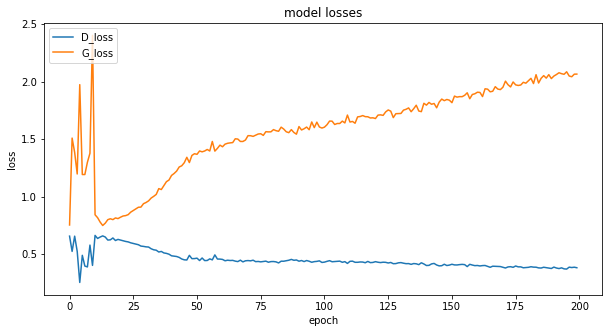

In [18]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=200, n_batch=128):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	d_loss_1=[]
	g_loss_1=[]
	# manually enumerate epochs
	for i in range(n_epochs):
		d_loss_d=[]
		g_loss_g=[]
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# create training set for the discriminator
			X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
			# update discriminator model weights
			d_loss, _ = d_model.train_on_batch(X, y)
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			# summarize loss on this batch
			print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))
			#print(d_loss)
			d_loss_d.append(d_loss)
			g_loss_g.append(g_loss)
            #sum(lst) / len(lst)
		# evaluate the model performance, sometimes

		if (i+1) % 10 == 0:
			summarize_performance(i, g_model, d_model, dataset, latent_dim)
		d_loss_1.append(sum(d_loss_d) / len(d_loss_d))
		g_loss_1.append(sum(g_loss_g) / len(g_loss_g))
		print('d_loss_1_length='+str(len(d_loss_1)))
        # summarize history for loss
	plt.figure(figsize=(10, 5))
	plt.plot(range(len(d_loss_1)),d_loss_1)
	plt.plot(range(len(g_loss_1)),g_loss_1)
	plt.title('model losses')
	plt.ylabel('loss')
	plt.xlabel('epoch')
	plt.legend(['D_loss', 'G_loss'], loc='upper left')
	plt.show()
 
# size of the latent space
latent_dim = 500
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples(training_data_np)
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

## 4. Use final generator model to generate images

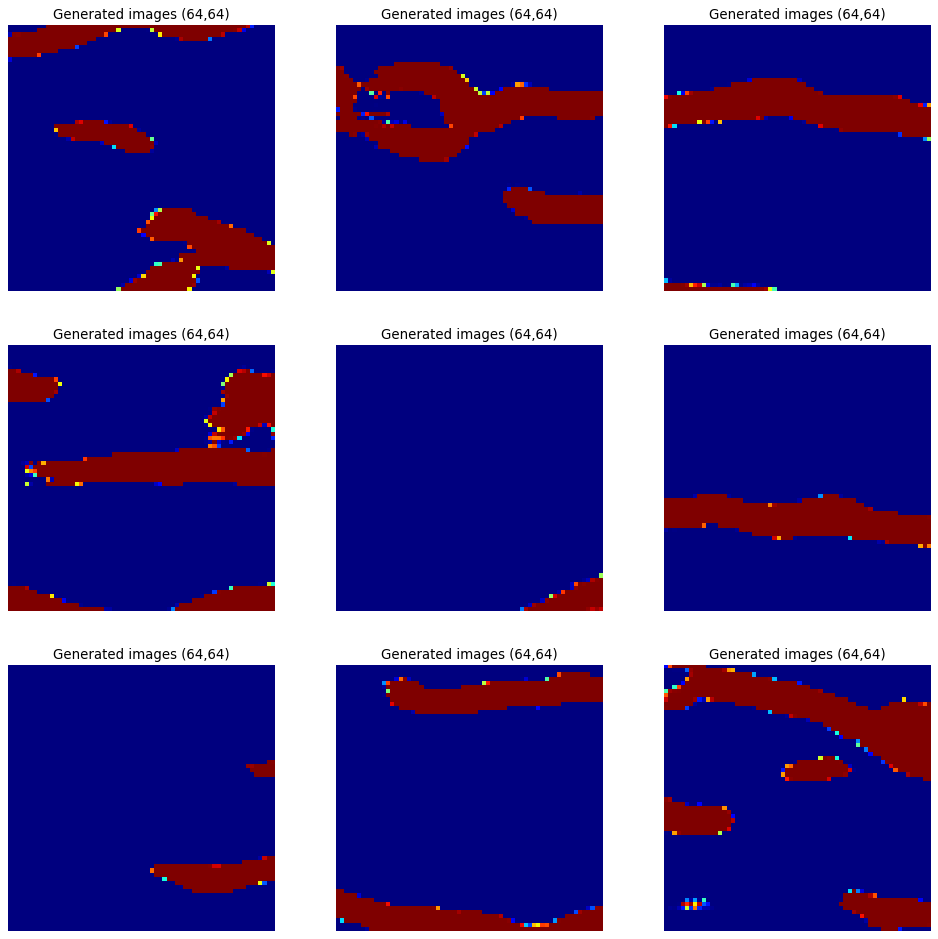

In [19]:
# example of loading the generator model and generating images
from keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot
 
 
# create and save a plot of generated images (reversed grayscale)
def plot1(examples, n):
	# plot images
	plt.figure(figsize=(15, 15), dpi=80)
	for i in range(n * n):
		# define subplot
        
		plt.subplot(n, n, 1 + i)
		# turn off axis
		plt.axis('off')
		# plot raw pixel data
		#plt.subplots_adjust(left=0.1, bottom=0.1, right=0.2, top=0.2, wspace=0.1, hspace=0.1)
		plt.imshow(examples[i, :, :, 0],interpolation='none')
		plt.title('Generated images (64,64)')
	pyplot.show()
 
# load model
model = load_model('generator_model_100.h5')
# generate images
latent_points = generate_latent_points(latent_dim, 1000)
# generate images
X = model.predict(latent_points)
# plot the result
plot1(X, 3)

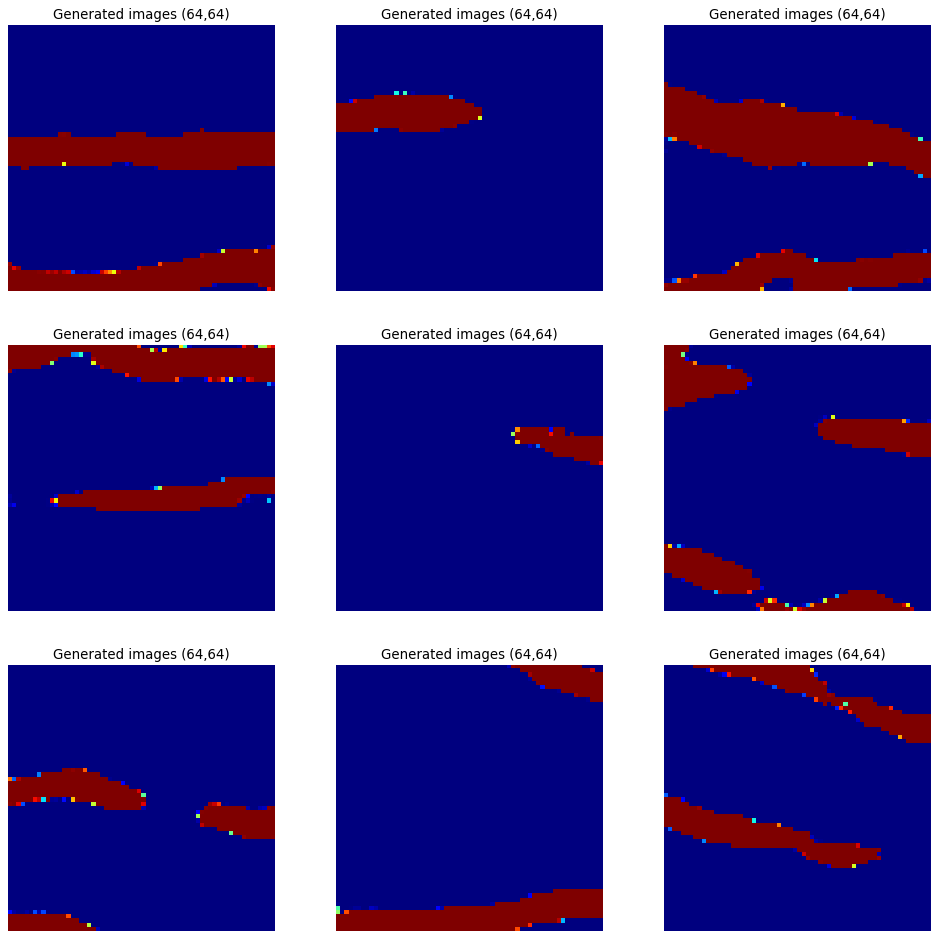

In [20]:
# load model
model = load_model('generator_model_150.h5')
# generate images
latent_points = generate_latent_points(latent_dim, 1000)
# generate images
X = model.predict(latent_points)
# plot the result
plot1(X, 3)

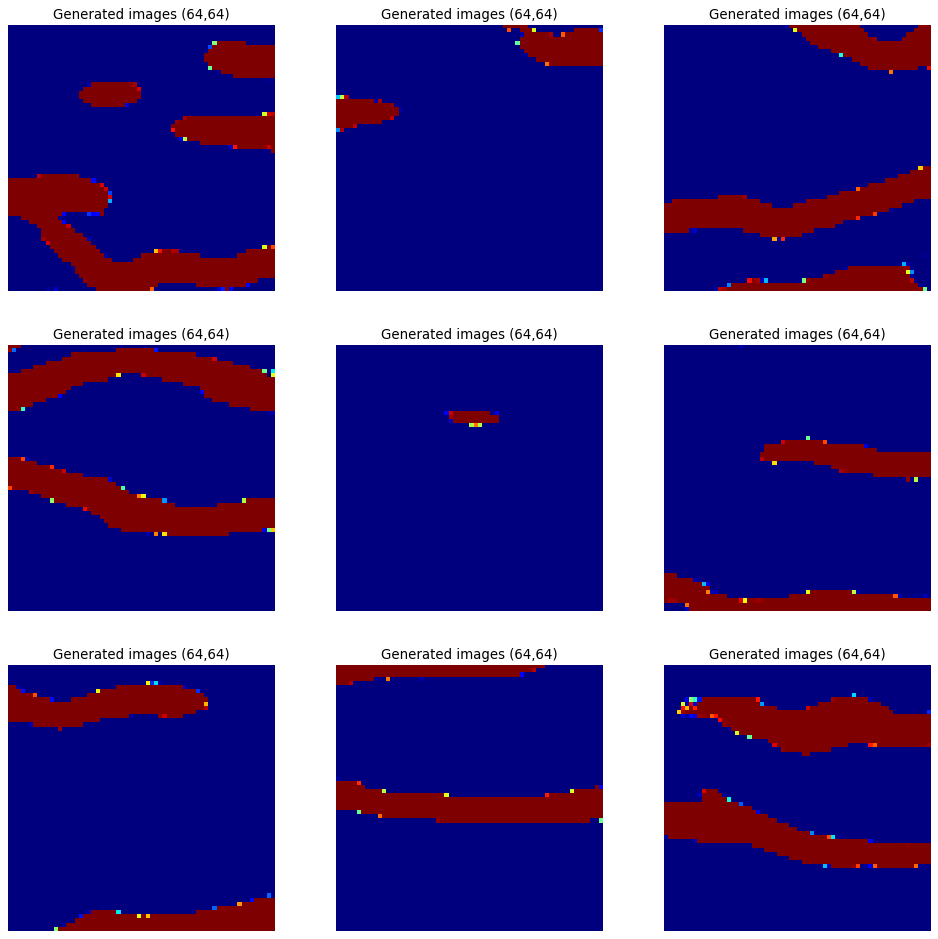

In [21]:
# load model
model = load_model('generator_model_200.h5')
# generate images
latent_points = generate_latent_points(latent_dim, 1000)
# generate images
X = model.predict(latent_points)
# plot the result
plot1(X, 3)

In [22]:
print(X.shape)
X_post=np.reshape(X,(len(X),X.shape[1],X.shape[1]))
print(X_post.shape)

(1000, 64, 64, 1)
(1000, 64, 64)


# 5. QC generated images

## QC training data

(64, 64)


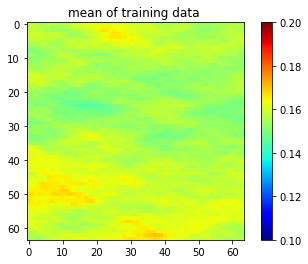

In [23]:
# mean
mean_training=np.mean(training_data_np, axis=0)
print(mean_training.shape)
plt.imshow(mean_training,interpolation='none')
plt.jet()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.title('mean of training data ')
c=plt.colorbar()
plt.clim(0.1, 0.2)

(64, 64)


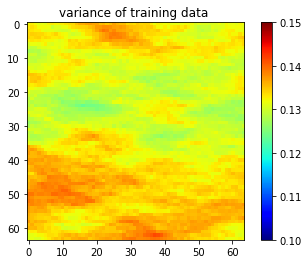

In [24]:
# var
var_training=np.var(training_data_np, axis=0)
print(var_training.shape)
plt.imshow(var_training,interpolation='none')
plt.jet()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.title('variance of training data ')
c=plt.colorbar()
plt.clim(0.1, 0.15)

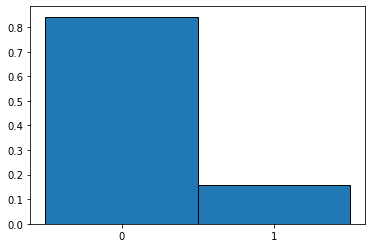

In [25]:
#histogram
plt.hist(training_data_np.flatten(), bins=[-.5,.5,1.5],ec="k",density=True)
#plt.hist(img.flatten(), bins=[-.5,.5,1.5], ec="k")
plt.xticks((0,1))
plt.show()

## QC predicted data

(64, 64)


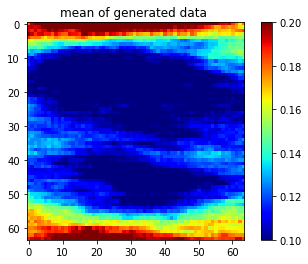

In [26]:
# mean
mean_gener=np.mean(X_post, axis=0)
print(mean_gener.shape)
plt.imshow(mean_gener,interpolation='none')
plt.jet()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.title('mean of generated data ')
c=plt.colorbar()
plt.clim(0.1, 0.2)

(64, 64)


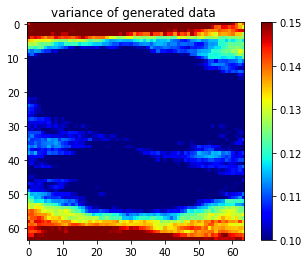

In [27]:
# var
var_gen=np.var(X_post, axis=0)
print(var_gen.shape)
plt.imshow(var_gen,interpolation='none')
plt.jet()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.title('variance of generated data ')
c=plt.colorbar()
plt.clim(0.1, 0.15)

In [28]:
print(X_post.shape)

(1000, 64, 64)


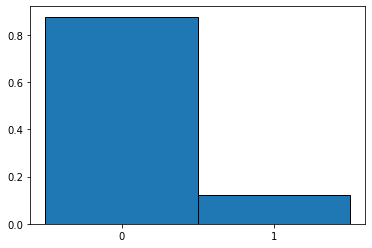

In [29]:
plt.hist(X_post.flatten(), bins=[-.5,.5,1.5],ec="k",density=True)
#plt.hist(img.flatten(), bins=[-.5,.5,1.5], ec="k")
plt.xticks((0,1))
plt.show()